In [99]:
# Standard
from __future__ import annotations

import itertools as it
import json
import os
from pathlib import Path
from typing import Self

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import seaborn.objects as so
from scipy import optimize
from scipy.interpolate import interp1d

# Configure seaborn
sns.set_theme(
    style="whitegrid",
    rc={
        "legend.framealpha": 0.2,
    },
)

root = Path().resolve()
root

PosixPath('/home/jeppe/JaxIsingModel')

In [100]:
# Extended
import equinox as eqx
import jax.config
import jax.numpy as jnp
import lmfit
from jax import lax, random
from jaxtyping import Array, Bool, UInt
from tqdm.notebook import tqdm

from jackpot.algorithms.base import Algorithm
from jackpot.algorithms.cluster import ClusterAlgorithm
from jackpot.algorithms.glauber import GlauberAlgorithm
from jackpot.algorithms.metropolis_hastings import metropolis_hastings_accept
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import Measurement
from jackpot.primitives.local import get_random_point_idx
from jackpot.primitives.state import get_trial_spin
from jackpot.state import State
from jackpot.typing import RNGKey
from jackpot.utils.graph import show
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

# Force usage of CPU in this notebook only
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_platforms", "cpu")

# CPU cores as separate devices
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

# Jackpot – a scalable, generalised Ising Model simulator

Submitted: 2023-05-01

## Abstract

We present _Jackpot_, a Python framework enabling scalable lattice model simulations on CPU, GPU, and TPU hardware by leveraging the JAX library. The framework features a prebuilt generalised N-dimensional Ising Model and implementations of the Glauber, Metropolis-Hastings, Wolff and Swendsen-Wang algorithms. The performance of the Wolff algorithm was determined to be $≈50,000\%$ faster than a naïve single-threaded NumPy implementation when running on a TPUv2-8 VM. Simulations of system sizes up to $L^D=256^2$ and $L^D = 64^3$ were undertaken and estimates of the critical exponents and temperature were performed. The critical temperature of an infinite 2D lattice was estimated to be within $T_c(D=2, L=∞, J=1 H=0, S=1/2) = 1.133±0.004$, which is in agreement with existing literature and the analytical result. Similarly the critical temperature of the 3D lattice was determined to be within $T_c(D=3, L=∞, J=1, H=0, S=1/2) = 2.256±0.002$.

## Introduction
The understanding of phase transitions in physical systems is often aided by simulations of _lattice models_, with perhaps the most famous example being the revered _Ising Model_,
which is often formulated as a two-dimensional square lattice of _spins_ that may adopt
one of two states $\{-1, +1\}$. Remarkably, when neighbouring spins on the lattice are taken to
interact with a coupling strength $J$ and the system is evolved in a manner that satisfies the principle of _detailed balance_, a phase transition be observed at a critical point as defined by an independent parameter of the system, which will be the inverse temperature $β ≡ \frac{1}{k_B T}$ when working with Boltzmann distributions.

The Ising Model is further generalised by the _Potts Model_, which again may be generalised into the _$N$-Vector Model_, which also encapsulates the _Heisenberg Model_ and _XY Model_, all of which are important models in statistical mechanics and condensed matter physics, though they occassionally find also find uses in network theory, quantitative sociology (van der Maas et al., 2020) and beyond.

Evolving a system such that it reaches an equilibrium position and subsequently sampling different uncorrelated states of the equilibrated system proves to be a very computationally intensive process. A variety of different algorithms exist that obey the detailed balance criterion and the requirement of ergodicity while trying to propagate and sample the model states as efficiently as possible, where a notable example of a _local algorithm_ is the famous _Metropolis-Hastings algorithm_, though it is often preferable for larger lattice sizes to work with a _cluster algorithm_. These are characterised by their ability to change multiple lattice sites per iteration with the _Wolff algorithm_ being a common choice.

_Jackpot_ is a framework for working with a variety of different lattice models and algorithms in a highly scalable manner and makes use of the XLA (_Accelerated Linear Algebra_, (XLA, Google, n.d.)) compiler from Google in order to target fast and energy-efficient accelerator hardware such as NVIDIA GPU's and Google TPU's (_Tensor Processing Units_, (TPU, Google, n.d.)) in addition to traditional parallelised CPU-based execution. _Jackpot_ lends its name from a combination of the XLA frontend `jax` and the famous _Potts Model_, the implementation of which is a planned future feature of _Jackpot_.

## A Reader's Guide

Due to a rather debilitating inability to contain my enthusiasm for both computer science and physics, the combination of these two areas in a single report in addition the somewhat more relaxed formal requirements of the report has resulted in the project growing to include a study into the scalability of computational physics problems and how to leverage recent advances in hardware and frameworks for working with linear algebra. This was aided and abetted by an extraordinarily generous grant of computing time on Google's TPU Research Cloud (TRC).

The reports starts out with a brief discussion of the physics we are trying to simulate – while all key concepts and formulae are reproduced in the report, their derivations are omitted to the benefit of the impatient reader, who may subsequently gain further insight by perusing the cited publications in any areas that may remain unclear.

Following the physical foundation, the challenges of scaling scientific computing problems is briefly discussed and the constraints imposed by solving these using the JAX framework are presented. This material is expected to be unfamiliar to the reader and the unique implications of using JAX are important in understanding the design decisions covered in the presentation of the implementation.

As the reader progresses through the report, they will be met with an increasing density of of code, though they may wish to supplement this by referring to the Python code located in the `jackpot/` folder in addition to other Jupyter notebooks found in the project directory. These are heavily laden with comments and _docstrings_ in order to gently guide the reader's understanding.

The beginning of the report is fairly information dense, but the patient reader is rewarded in the later parts of the notebook.

### Executing this notebook

While the project description formally requires the report notebook to be executable using only _standard_ scientific Python libraries, it was deemed appropriate to slightly circumvent this requirement in order to have a more interesting, integrated notebook.

If only standard libraries are installed, simply only execute cells that begin with `# Standard` and refrain from executing those beginning with `# Extended`.

Should the reader wish to be able to execute `# Extended` cells, they can easily install all the required packages using [Poetry](https://python-poetry.org/) by running `poetry install` in the report root directory. This is the recommended approach.

## Theory - Physics

### A Brief Introduction to Lattice Models
While this project is primarily focused on the computational approaches to working with lattice models and how to best solve the problems around scaling them, it is important to have a thorough understanding of the physical behaviour of the system we are trying to simulate. A very thorough description of the Ising Model is given in the the somewhat ironically named publication "_A Brief Account of the Ising and Ising-like Models_" by Jozef Strečka and Michal Jaščur (Strecka and Jaščur, 2015), though much of this is concerned with the more analytically tractable _mean field_ approaches to solving the Ising Model, whereas we wish to explore the _exact field_ version of the model by leveraging our computational implementation.

While the Ising Model is most commonly studied in two dimensions, we will do away with this constraint and develop our understanding using an arbitrary number of dimensions, drawing examples from a two-dimensional system where these may benefit our understanding.

Having lifted the constraint of two dimensions, we can further generalise the Ising Model by instead moving to the _Potts Model_ where we no longer limit the number of possible spin states to just two, but rather $q$ different discrete spin states. 

Additionally, we can introduce more interaction parameters such as an external interacting field that encourages spins to align in a particular spin state over another or we can have interaction effects that go beyond merely the nearest neighbour on the lattice, which itself does not have to be hypercubic, but may take any crystal lattice structure and adopt an arbitrarily complex _motif_.

While we may wish to allow for all of these generalisations and more in our framework, we
will restrict ourselves to a hypercubic Ising Model with one a site in the motif. _Jackpot_ is written in a way where these generalisations can be lifted, though not as easily and interchangibly as changing the model or evolution algorithm.

#### An Aside on the Generality of Lattice Models
The description of lattice models above is heavily tinted by the physical framework within which lattice models often find their application. For example, one might want to avoid referring to the spin states as just that and instead adopt the more general terminology of lattice site states if investigating the model outside of a physical perspective, though we are physicists and will allow our familiar terminology here.

Indulge me as we venture away from the physical part of physics and instead apply our
physical intuition to another important dynamic system: society.

It is worthwhile keeping in mind that these models do have uses outside of physics and every physical, thermodynamic phenomenon must therefore, interestingly, have an equivalent quantity in whatever domain the model is applied to. For example, if the Ising Model is applied to party political affiliation along an axis mapping the wealth distributive policy of a system, one might adopt the public's political engagement as the temperature-like variable and find that systems with lower democratic activity will equilibrate into either a capitalist "phase" or a socialist "phase" below a critical point. This is analogous to how the magnetisation density is bifurcated below the critical temperature in the physical Ising Model – political systems tend to be somewhat more dynamic and harder to make fit into quantitative models than physical systems, though anecdotally the American two-party system does seem to be "too cold" to exist in a single phase – one might wonder what intensive variable might be tuned to overcome the the phenomenon of political polarisation – Perhaps the Information Age has lead to an increase in the linear interaction parameter $J$, which would in turn increase the critical "temperature" $T_c$ needed to prevent precipitation.

Be warned: when you allow yourself to observe physics outside the traditional domain of the discipline, its models start cropping up in the most peculiar places. 

As we recover from the frightful prospect of having briefly turned into _social scientists_ – two terms that normally exist in separate phases when interpreted either as a behavioural statement or a disciplinary description – we quickly return to the familiar embrace of the mathematical framework of statistical physics.

While a full regurgitation is beyond the scope of this report, we will introduce the Ising Model in some detail.

### The Ising Model

We construct an array of size $L^D$ that represents a trunctated hypercubic lattice with each element of the array representing a single lattice site, indexed by $i$, which may adopt values $s_i ∈ {±0.5}$ (note that this is sometimes taken to be ${±1}$ in the literature, which leads to a factor $2$ difference in the critical temperature value). Conceptually, it is helpful to arrange our array as an ND-array – that is, an array of $D$ axes, in which case our indexing variable $i$ becomes a set of numbers that uniquely index each site.

We can then give a geometrical meaning to our array and index by declaring that indices that vary by $±1$ along a single axis are said to be _neighbours_ – in the most general case these would be connected vertices on an arbitrary graph. It now becomes difficult not to imagine our array as an $D$-dimensional primitive hypercubic crystal, which is indeed a helpful picture to keep in mind. We will impose periodic boundary conditions by tweaking the indices as neccessary to cause the crystal to _wrap around_ itself which helps mitigate the edge effects of our truncated model. Note that due to the correlation of the spins on the lattice reaching beyond the size of the truncated model in many cases, periodic boundary conditions are not a perfect fix. In fact, it is an interesting problem in its own right to observe how the point of criticality scales with the lattice size as we shall see.

Next we want to introduce an interaction Hamiltonian that describes how the energy of our system arises as a function of the spins and their neighbourly interactions. For the Ising Model a generalised interaction Hamiltonian could look like (Taheridehkordi and Zivieri, 2020):

$$
𝒣(s) =
-\sum_{<ij>} J_{ij} s_i s_j
-\sum_{<ij>} K_{ij} s_i^2 s_j^2
-\sum_{i=0}^{L^D - 1} D_i s_i^2
-\sum_{<ij>} L_{ij} (s_i^2 s_j + s_i s_j^2)
-\sum_{i=0}^{L^D - 1} μ_i H_i s_i
$$

Where $<ij>$ sums over neighbouring sites only and $i,j$ are taken to the the "flat" indices of our array – that is, for the purposes of the definition above, the geometrical structure of the array has been moved from the indexing variable to the $<ij>$ operation. Note that varying definitions of $<ij>$ and whether to "double count" generally leads to another factor $2$ difference in the numerical value of the critical temperature, $T_c$.

The coefficients are given the following names:
- $J$: Linear Interaction Coefficient
- $K$: Biquadratic Interaction Coefficient
- $D$: Anisotropy Coefficient
- $L$: Bicubic Interaction Coefficient
- $μ$: Nuclear Magnetic Moment
- $H$: External Magnetic Field Strength

Often many of these parameters are set to $1$ or $0$, and it is common to find $K = D = L = 0$ and $J = μH = 1$ in papers that explore more exotic interactions. Additionally, it is often assumed that the coefficients are independent of the lattice sites such that $J_{ij} = J$, for example. The rest of the report assumes $D$ and $L$ refers to the dimensionality and axis length of the truncated lattice rather than the anisotropy and bicubic interaction coefficients.

### Statistical and Thermodynamic Foundation
The _configuration probability_ $P(s, β)$ of the system then follows a Boltzmann Distribution:

$$
P(s, β) = \frac{e^{-β𝒣(s)}}{\sum_{s} e^{-β𝒣(s)}}
$$

Interestingly, we are already able to determine thermodynamic quantities about a given state $s$ by recognizing the partition function in the denominator of the configuration probability:

$$
Z(s, β) = \sum_{s} e^{-β𝒣(s)}
$$

From which we can recover the magnetisation density $M$ as (Taheridehkordi and Zivieri, 2020):

$$
m(s) = \frac{1}{L^D} \sum_{i=0}^{L^D -1} s_i
$$

Further, using the _fluctuation-dissipation theorem_ and our knowledge of statistical physics, we can recover expressions for the specific heat capacity $C$ and the _initial_ magnetic susceptibility $χ$ for systems where the external magnetic field interaction is off, $H_i = 0$ (Strecka and Jaščur, 2015)(Taheridehkordi and Zivieri, 2020):

$$
C(s, β)
= \frac{\langle 𝒣(s)^2 \rangle - \langle 𝒣(s) \rangle^2}{k_B T^2}
= \frac{∂𝒣(s)}{∂T}
$$

$$
χ(s, β, H=0)
= β L^D \left(\langle m(s)^2 \rangle - \langle m(s) \rangle^2\right)
= L^D \left| \frac{∂m(s)}{∂T}\right|
$$

Recalling that:
$$
β ≡ \frac{1}{k_B T}
$$




#### Correlation Length and Critical Phenomena

It will be instructive to introduce a _correlation length_, $ξ$, which describes the characteristic length with which spins on the lattice are correlated (Timothy Budd, n.d.). The magnitude of this length is particularly interesting when applied to our computational model, as they are observed to diverge as the temperature approaches criticality around $T_c$ (Timothy Budd, n.d.):

$$
ξ ∼ \left| T - T_c \right|^{-ν} 
$$

Where $ν$ is said to be the _critical exponent_ of the correlation length $ξ$, with $T_c$ being the critical point where the phase transition is observed. In fact, we are able to find _critical exponents_ associated with all of the thermodynamic quantities defined above (Lundow and Campbell, 2018):

| Thermodynamic Quantity  | Quantity Symbol | Critical Exponent |
| ----------------------- | :-------------: | :---------------: |
| Specific Heat Capacity  | $C$             | $α$                |
| Magnetisation Density   | $m$             | $β$                | 
| Magnetic Susceptibility | $χ$             | $γ$                |
| Correlation Length      | $ξ$             | $ν$                |

Notably the thermodynamic quantities are only expected to go to their infinite limit in the case of an infinite sized lattice, but nonetheless observed to diverge for finite lattice sizes. Again, the reader is trusted to distinguish between the critical exponent of the magnetisation and the inverse temperature, both denoted by $β$.

The expression of the correlation length $ξ$ will later be discussed in order to understand the performance of different types of algorithms that may be used to solve the Ising Model.


### Determination of the Point of Criticality

Additionally, we find that the critical temperature, $T_c(L)$, of the system to be dependent on the lattice size, but may wish to find the true critical temperature, $T_c(∞)$, for a system with an infinite lattice size. This may be achieved by introducing the second and fourth order Binder Cumulants (Selke, 2006), whose crossings when observed for different lattice sizes reveals the location of $T_c(∞)$. While different formulations exist, we choose to define the cumulants as:

$$
U_2(s) ≡ 1 - \frac{\langle m(s)^2 \rangle}{\left[\langle \left |m(s) \right| \rangle\right]^2}
$$

$$
U_4(s) ≡ \frac{1}{3} - \frac{\langle m(s)^4 \rangle}{3 \left[\langle m^2(s) \rangle\right]^2}
$$

## Theory - Computational

While computation is a significant part of most branches of physics, advances in hardware and software design enable us to improve our understanding of physics through increasingly large and complex simulations of physical systems. While this project is focused on the Ising Model and simulations of the Ising Model, this is largely used example of why computational physics is important, what makes it difficult, and how simulations can be scaled. 

### Achieving Computational Efficiency and Scalability

It is often possible to write an algorithm in a conceptually simple manner by using intuition and computational primitives like loops alone. A popular choice within scientific circles is Python and its extensive suite of scientifically oriented libraries with notable examples being `numpy`, `SciPy`, and `pandas`.

Being a fully interpretted language, as opposed to a compiled language or just-in-time compiled language (note that JIT implementations of Python do exist and the main Python implementation, CPython, is currently taking steps towards implementing JIT specialisation techniques), Python is often criticised for being hopelessly slow.

This is mitigated somewhat by implementing numerically intense functionality in compiled languages – often C, C++ or FORTRAN – "under the hood" and calling these from Python. These libraries are able to use principles like _vectorisation_ and _parallelisation_, allowing several computations to be performed in a single CPU cycle or across multiple CPU cores respectively.

An additional technique that is becoming increasingly common is leveraging specialised hardware that is able to perform specific operations much more quickly (and power-efficiently) than CPU's, though implementing algorithms that target specialised hardware is often difficult and generally requires compilation targetting the architecture in question. For example, very few machine learning applications will target traditional CPU's, which are largely replaced by GPU's and, more exotically, TPU's.

In summary, we may implement some of the following techniques in order to improve the computational efficiency of our algorithm:
- Vectorisation — compute multiple values at the same time on a single core
- Parallelisation — split computation across multiple cores
- Target accelerators (GPU, TPU) – compute on devices that specialise in certain operations
- Use compiled software that can implement tricks and hardware specialisations




### `jax` Constraints

While these will be elaborated on later, in order to be able to target GPU and TPU architecture, the `jax` library places a number of constraints on our implementation.

#### Pure Functions

All code that must be run on a target device – that is, all code that is compiled and given to a CPU, GPU, or TPU to run – must be implemented using _pure functions_, which cannot have any side-effects. Much like in mathematics, these functions can only manifest change through their output, and can only take parameters as an input.

They cannot, for example, write or read from storage or access a global variable.

#### Mutability

As a consequence, we cannot mutate objects within a `jax` context. If we wish to mutate something, we must make a copy, apply our changes to the copy and return the copy.

All state of our implementation is thus necessarily explicit.

#### Memory Layout

Given we must compile our code ahead of time and feed the resultant code to a device, we have to know our memory layout ahead of time. In order to do this, we _must_ know the shape and type of all data when we compile our code. We cannot have run-time execution that allocates memory.

We can use Python control flow only when strictly brancing off static values that are known at compile time. If we need to do control flow at run-time, this has to be implemented using `jax.lax` primitives, in which case each branch of the control flow is compiled and the appropriate branch is executed using a switch at run-time.


### Monte-Carlo Simulations

While introducing the topic of Monte-Carlo simulations with the appropriate level of rigour would instructive, it falls outside the scope of this report. Instead, we recall that they are probabilistic models that work by sampling many possible states of an outcome and in doing so producing an estimate of a value.

For our model, it becomes crucial to find an algorithm that allows us to explore different, _uncorrelated_ states, $s$, in an efficient manner while obeying the _detailed balance condition_:

$$
P_{jk} π_k = π_j P_{kj}
$$

Where $π_j$ denotes an equilibrium configuration $j$ and $P_{kj}$ denotes a probability of transferring into this configuration from a different equilibrium configuration $k$. As such, our detailed balance condition simply states that our transitions are equally likely to go in either direction at equilibrium.


### Lattice Algorithms

In order to do to Monte-Carlo Simulations, we need a way to obtain different samples (or configurations, depending on your terminology of choice) of the system quickly. Crucially, these need to _uncorrelated_. As discussed in the section covering the physical theory, the _correlation length_, $ξ$, diverges at the critical point of the phase transition, which proves problematic for some lattice algorithms, namely those that fall into the category of _local lattice algorithms_. 

We may define a _characteristic decorrelation time_, $τ$, which captures the time in units of algorithmic steps that it takes for the _autocorrelation_, $acf(t)$, of a quantity of the system to the decay by a factor of $1/e$. Strictly, we define it as:

$$
ac(t) ≡ acov(t) / acov(0)
$$

Where $acov(t)$ is the _autocovariance_ of the quantity with respect to time:

$$
acov(t) ≡ \langle Q'(t') Q'(t' + t)\rangle
$$

With $Q'(t)$ being the deviation from the mean measurement of a quantity $Q$ at time $t$, that is: $Q'(t) ≡ Q(t) - \langle Q \rangle$.

Importantly, the means are assumed to be taken over a time that is significantly longer than the characteristic decorrelation time $τ$.

#### Local Lattice Algorithms
For _local lattice algorithms_ such as the Metropolis-Hastings algorithm, the Heat Bath algorithm, Glauber Dynamics and others, the decorrelation time of a theoretical infinitely sized lattice diverges around the critical point. This can be understood intuitively by recalling that the correlation length $ξ$ is divergent around the point of criticality, which leads to correlation effects – effectively clusters in the case of $J > 0$ – becoming infinitely far-reaching, thus requiring many lattice site updates to move to a different entirely decorrelated configuration.

Even on models of relatively limited lattice sizes, the characteristic decorrelation time becomes sufficiently large to render it computationally intractible to simulate systems near criticality using local lattice algorithms.



##### The Metropolis-Hastings Algorithm

The Metropolis-Hastings Algorithm is a popular local lattice algorithm and widely used, but suffers from the problem outlined above that plagues all algorithms of this category.

The algorithm is fairly simple and may be formulated thusly:
1. Choose a site with index $i$ on the site randomly
2. Pick a random trial spin, $s_t$, that is different to the current spin $s_i$
3. Compute the energy difference $Δ𝒣_{i→t}$ of changing the site from $s_i$ to $s_t$
4. Compute the acceptance criterion $𝒜$
$$
𝒜_{MH, i → t} =
\begin{cases}
    1 & \text{if } Δ𝒣_{i→t} < 0\\
    \exp(-β Δ𝒣_{i→t}) & \text{otherwise}\\
\end{cases}
$$
5. Pick a random number $r ∈ \left[0, 1\right]$
6. If $𝒜_{i → t} ≥ r$ set the site with index $i$ to the trial spin $s_t$

We can plot the acceptance function as a function of temperature, assuming a $Δ𝒣_{i→t} ∼ 1$:

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


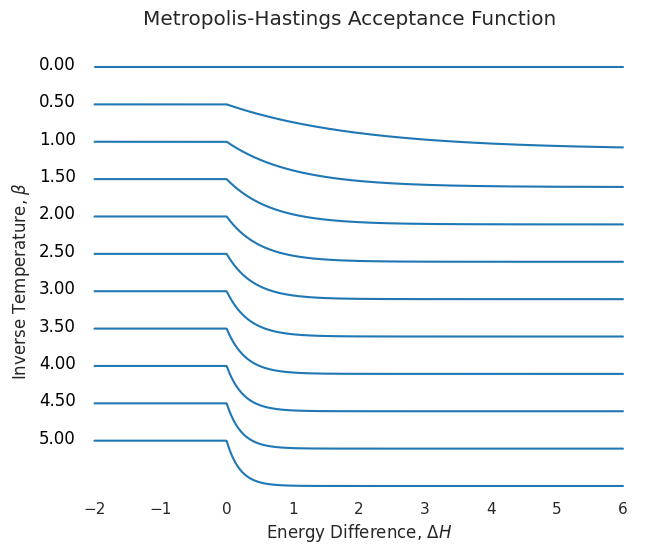

In [101]:
# Standard

# Prepare data
beta = np.linspace(0, 5, 11)
delta = np.linspace(-2, 6, 1000)

df = pd.DataFrame(it.product(beta, delta), columns=["beta", "delta"])


def mh_accept(row):
    """
    Metropolis-Hastings Acceptance Criterion
    """
    if row["delta"] < 0:
        return 1.0
    return np.exp(-row["beta"] * row["delta"])


df["accept"] = df.apply(mh_accept, axis="columns")

# Plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(df, row="beta", hue="beta", aspect=15, height=0.5)

g.map(
    sns.lineplot,
    "delta",
    "accept",
    clip_on=False,
    alpha=1,
    linewidth=1.5,
    color="tab:blue",
)

def label(x, color, label):
    label = f"{float(label):.2f}"
    ax = plt.gca()
    ax.text(
        -0.05, 1.0, label, color="black", ha="left", va="center", transform=ax.transAxes
    )


g.map(label, "beta")
g.figure.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.suptitle("Metropolis-Hastings Acceptance Function")
plt.title(
    "Inverse Temperature, $β$", rotation=90, ha="left", va="center", x=-0.1, y=4.0
)
plt.xlabel("Energy Difference, $ΔH$");


##### Glauber Algorithm

The Glauber algorithm follows the same steps as the Metropolis-Hastings algorithm except
with a slightly different acceptance criterion: 

$$
𝒜_{G, i → t} = \frac{1}{1 + \exp(β Δ𝒣_{i→t})}
$$

Variations of these algorithms exist and they are sometimes implemented as _checkerboard_ algorithms to improve the computational efficiency of them (Yang et al., 2019).

Notably the Metropolis-Hastings and the Glauber algorithm have high _rejection_ rates – that is, an iteration will yield the same state as the input state.

#### Cluster Algorithms

In order to mitigate against the adverse effects on the correlation time through configurations with large correlation lengths, $ξ$, we may employ the use of _cluster algorithms_. They get around this problem by working with whole clusters of like spins rather than a single spin at a time.

These are generally preferred over local algorithms and are not much more complicated to implement in most cases. If we weren't concerned about performance and didn't have the many extra constraints imposed by running in JAX and on GPU/TPU hardware, we could get away with a solution like the one outlined in (Timothy Budd, n.d.).

##### Wolff Algorithm
In order to aid the reader's appreciation of JAX and why running software directly on a device such as the TPU is non-trivial, we will go over the implementation of the popular _Wolff algorithm_ in JAX and Equinox here. The actual implementation can be found in `jackpot/algorithms/cluster.py` and `jackpot/algorithms/wolff.py`.

In addition to (Timothy Budd, n.d.), (deLyra, 2006) proved a valuable introduction to the Wolff algorithm.

For visualisation purposes, we will use a $L=4$, $D=2$ system with only two possible spin states. We draw the two spins states either a blue or a red circle.

Next, we connected _neighbouring_ sites with _the same spin state_ together using a link with a probability $P_{link}$:

$$
P_{link} ≡ 1 - \exp(𝒧(J, K, L) β)
$$

Where $𝒧(J, K, L)$ is a the _linkage probability factor_ and determined based on the interaction coefficients between neighbouring spins – not that $𝒧$ is not a function of the environmental interaction coefficients $H$ or $D$.

In many papers the more complicated interaction effects are not considered and we find $𝒧 ≡ - 2J$, taking into consideration factors of 2 depending on the way the model is defined as mentioned previously.

This produces a graph such as the one depicted here, noting the periodic boundary conditions:

![Wolff Spins](images/wolff_spins.png)

Now that we have successfully linked our spins into clusters, we choose a random cluster and "flip" it – or randomise it in the case of more than 2 spin states. We note that the Wolff algorithm is _rejection free_ when defined as it is here. Unfortunately, we also note that it does not take into consideration environmental effects at all. For this reason, we may choose to modify it such that we only accept trial clusters with a Metropolis-Hastings-like acceptance function based on the energy change of the transition, which allows us to capture these interactions in the dynamics of our algorithm as well. This is only necessary for parameters $H ≠ 0$ or $D ≠ 0$.

## Implementation of Wolff Algorithm using `jax`
Now we are left with the somewhat daunting task of implementing this in JAX in a way that does not involve a mess of `lax` primitives while also emphasising performance.

By starring at the cluster-spin diagram above for sufficiently long, we realise that we can produce an array of booleans that hold our links if we copy the shape of the spin array and add a leading axis with a number of elements equal to our dimensionality. That is, we need a link array of shape:
$$
\text{shape(links)} = ( D, \underbrace{L, L, ...}_{D})
$$

We introduce a new Equinox module that holds the data associated with our _cluster solution_. It proved necessary to take a few attempts at an implementation before finding one that was sufficiently aesthetically pleasing and, crucially, works.

In [102]:
# Extended
# Taken directly from `jackpot/algorithms/cluster.py`
class ClusterSolution(eqx.Module):
    """
    A traditional cluster solver found in many Wolff and Swendsen-Wang papers
    does not work within a JAX context as the shape of neighbours in a cluster
    cannot be known at compile time and thus cannot be probed using array
    programming approaches.

    This forces us to come up with a fully vectorised clustering solution,
    which incidentally is also very efficient.

    While the code below looks tiny, it took an awfully long time to come
    up with this solution after trying less vectorised versions that relied
    on a large number of LAX primitives.

    Additionally this solves the problem of multiple visits which many iterative
    approaches neglect. If not mitigated against, this leads to linking rates
    that are too high, especially in higher dimensional spaces.
    """

    rng_key: RNGKey
    links: Bool[Array, "ndim *dims"]

    @classmethod
    @eqx.filter_jit
    def clusterise_state(cls, rng_key: RNGKey, state: State) -> Self:
        """
        This runs our clustering algorithm (not cluster algorithm) on a state
        and returns a ClusterSolution.
        """
        spins = state.spins
        shape = spins.shape

        # Construct an array where the first axis holds the different layers
        # Each layer corresponds to neighbours along a particular dimensional axis
        neighbours = jnp.empty((spins.ndim, *shape), dtype=spins.dtype)
        for i in range(spins.ndim):
            neighbours = neighbours.at[i].set(jnp.roll(spins, shift=-1, axis=i))

        # Compute a link factor for each neighbour site
        link_factors = state.model.get_cluster_linkage_factors(
            state=state, spins=spins, neighbours=neighbours
        )

        # Threshold value that our random number must be below for us to
        # establish a link
        link_thresholds = 1.0 - jnp.exp(link_factors)

        # Generate a random number for each site.
        # In Wolff algorithm where only a single cluster is flipped it might
        # seem a bit excessive to generate this many numbers since PRNG generation
        # is expensive.
        # It has to be done this way though as the number of sites in a cluster
        # cannot be known and we require known shapes at compile time
        # Generating unused keys is a small price compared to the efficiency of
        # doing the clustering in a vectorised manner.
        randoms = random.uniform(key=rng_key, shape=link_thresholds.shape)

        # Establish all links
        # After this, our spin-link graph is fully computed
        # Selecting the generated clusters is a difficult problem in its own
        # right in a vectorised context. This responsibility is given to
        # the ClusterSelection class.
        links = link_thresholds > randoms

        return ClusterSolution(rng_key=rng_key, links=links)

We want to try out our fancy new algorithm on a system, so let's make one and learn a little about the design of the `jackpot` library developed as part of this project.

We need a physical model. The model is a class that must implement the possible spin
states and have methods that return the Hamiltonian of a state, the energy change
of a state given a transition, and the linkage factors used in our cluster solution.
Notably the model class is entirely decoupled from the algorithm implementation
and implementing new models is quite simple. Let's build an Ising Model using the implementation in `jackpot/models/ising.py`:

In [103]:
# Extended
model = IsingModel.new(
    spin=0.5,  # ⇒ Possible spin states: -0.5, +0.5
    interaction_bilinear=1.0,  # J
    interaction_biquadratic=0.0,  # K
    interaction_anisotropy=0.0,  # D
    interaction_bicubic=0.0,  # L
    interaction_external_field=0.0,  # H
    nuclear_magnetic_moment=1.0,  # μ
)

Next we need to get a `State` object. A state is effective a _configuration_ or _sample_ as defined in the sections covering Monte Carlo algorithms and the thermodynamic foundations of the project. Notably the state object also implements some convenient logic, but is nothing more than a [`PyTree`](https://jax.readthedocs.io/en/latest/pytrees.html) with some methods attached – these methods can only take the instantiated object as an input and must manifest any modifications to the state by returning a new state, as we are subject to the requirement that all JAX functions must be pure and thus cannot modify the state mutably.

The state, in addition to holding the spin configuration on the lattice, also has an `id` value, a count of how many algorithmic steps or sweeps it has undergone, the inverse temperature of the state, and the lattice algorithm and model associated with the state.

This is captured in the beginning of the definition of `State`:
```python
class State(EnsamblableModule):
    """
    Represents an (immutable) state of the system.

    This object should contain all information about the system,
    how to measure the system and how to evolve the state.
    """

    spins: TSpins
    beta: Float[Array, ""]

    model: Model
    algorithm: Algorithm

    id_: int
    steps: int = 0
    sweeps: int = 0
    ...
```

Let's make a new state from a random distribution. To do that, we need some randomness. While inside of a JAX-context we cannot conjure up any randomness, as this would mean our function would not be pure, we don't suffer that restriction when inside a regular Python context. `EasyKey` is simply a neat class that makes it easy to get a fresh RNG key for JAX.

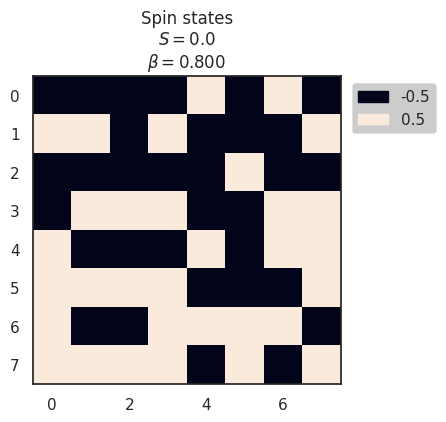

In [104]:
# Extended
# We can easily get RNG keys from EasyKey
k = EasyKey(seed=1234)  # k.new → gives a new RNG key and mutates the EasyKey instance

# We need to pass in an Algorithm object as well, but we won't use that for now.
# We will pass in a Glauber algorithm, but we won't use it here
glauber_alg = GlauberAlgorithm()

state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=2,
    size=8,
    beta=0.8,
    model=model,
    algorithm=glauber_alg,
    id_=0,
)

state.plot();

We can now demonstrate that our clustering algorithm works

In [105]:
# Extended
cluster_solution = ClusterSolution.clusterise_state(rng_key=k.new, state=state)
cluster_solution.links.astype(int)

Array([[[0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 1],
        [1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]]], dtype=int32)

While the links of the cluster could arguably be presented more nicely, each `1` of the array marks a single link between two neighbouring states. We can also see that we have two layers of links, one corresponding to the horizontal dimension and one corresponding to the vertical dimension. In the figure with the spin-link diagram, these links are more clearly indicated through two differently coloured bars denoting a formed link and two differently filled dots denoting an unformed link.

We now face a problem that might seem trivial, but having constructed our clusters, how do we flip a single cluster? This, within the confines of JAX, is surprisingly non-trivial. Initially the clustering and cluster selection algorithms were implemented in a single function and a single site was selected and links grown iteratively in a similar manner to what most implementations in the literature do. That begs the question, however, how many random keys do we need? We cannot run out, but JAX requires that we know our memory layout ahead of time, so we would need to generate all the keys up front or alternatively split and returns keys for each iteration. More importantly, how do we store our links? In regular Python an obvious (albeit impossible to vectorise) approach would be to store our link indices in a list that we append to. But JAX again requires the list to have a known size at compile time, and we would thus need a list with as many elements as we have in the link array above nonetheless.

Instead we will implement a separate cluster selection class where we have a boolean mask that denotes which spins are _selected_ and iteratively grow a seed site using the links we found above. The reason these two algorithms are located in separate classes is that the `ClusterSelection` objects are in fact the immutable states we transition over during our iterations.



In [106]:
# Extended
# Taken from `jackpot/algorithms/cluster.py`
class ClusterSelection(eqx.Module):
    selected: Bool[Array, "*dims"]
    cluster_solution: ClusterSolution
    is_done: bool
    steps: int
    """
    Marks a single selected cluster.

    This is done by iteratively following and marking sites from an initial
    seed site via the links obtained in the cluster solution.

    Together `cluster_solution.links` and `selected` make up a graph of spin
    sites and interconnecting links.

    This process is cannot be parallelised and cannot be vectorised
    further than what is done below (after for loop is unrolled at compile time).

    Attributes:
        selected: Array of bools masking which spin sites are part of this
            specific cluster.
        cluster_solution: A solution from the clustering routine.
            This object holds the probabilistically determined links
        is_done: boolean flag demarking whether cluster selection has terminated
        steps: number of steps it has taken to find cluster from seed index
        """

    @classmethod
    @eqx.filter_jit
    def new(
        cls, selected: Bool[Array, "*dims"], cluster_solution: ClusterSolution
    ) -> Self:
        return cls(
            selected=selected,
            cluster_solution=cluster_solution,
            is_done=False,
            steps=0,
        )

    @classmethod
    @eqx.filter_jit
    def from_seed_idx(
        cls, cluster_solution: ClusterSolution, seed_idx: UInt[Array, "a"]
    ) -> Self:
        """
        Find a full selection from a single seed site.

        Uses a un-unrollable while-loop underneath.
        """
        spins_shape = cluster_solution.links.shape[1:]
        selected = jnp.zeros(shape=spins_shape, dtype=bool)
        selected = selected.at[tuple(seed_idx)].set(True)

        selector = cls.new(selected=selected, cluster_solution=cluster_solution)
        selector = lax.while_loop(
            selector.should_continue, selector.expand_selection_step, selector
        )

        return selector

    @staticmethod
    @eqx.filter_jit
    def should_continue(cluster_selector: ClusterSelection) -> bool:
        """
        Used as part of the LAX `while_loop` to determine whether to exit loop.
        """
        return cluster_selector.is_done == False  # noqa: E712

    @staticmethod
    @eqx.filter_jit
    def expand_selection_step(cluster_selector: ClusterSelection) -> ClusterSelection:
        """
        A single step that expands our cluster selection by following the
        edges in our spin-link graph.
        """
        selector = cluster_selector
        solution = cluster_selector.cluster_solution
        # Holds all selected sites this round
        selected = selector.selected

        # This can be possibly be done with broadcasting,
        # but since we JIT anyway we prefer a more readable version.
        # Since selection shape is known at compile time this
        # embarrasingly paralllel loop gets unrolled trivially by XLA.
        for i in range(selector.selected.ndim):
            # i denotes the 'layer', where each layer corresponds to
            # links along a particular axis.
            # In 3D: [0] is the up-down axis, [1] is left-right, [2] is in-out
            # Below we use up/down notation for all axis though

            # All links connected to selected sites
            links_to_try = selector.selected | jnp.roll(selector.selected, -1, i)

            # Filter: only the links we have activated
            links_selected = links_to_try & solution.links[i]

            # Expand selected links since links are bidirectional
            links_selected = links_selected | jnp.roll(links_selected, 1, i)

            # Add newly selected sites
            selected = selected | links_selected

        # The sites that changed since last iteration
        new_sites = selected ^ selector.selected
        is_done = new_sites.sum() == 0

        return ClusterSelection(
            selected=selected,
            cluster_solution=solution,
            is_done=is_done,
            steps=selector.steps + 1,
        )

We apply this to select a single cluster in our state:

In [107]:
# Extended
seed_idx = (0, 2)
selection = ClusterSelection.from_seed_idx(
    cluster_solution=cluster_solution, seed_idx=seed_idx
)

Aside: This also offers a good demonstration of what the JAX authors generally refer to as JAX's _"sharp bits"_. As a consequence of objects being immutable, we can't do the following:

In [108]:
# Extended
# For demonstration purposes, let's try to modify a JAX array:
try:
    plot_selection = selection.selected.astype(int)
    plot_selection[seed_idx] = 2
except TypeError as e:
    print(f"Caught error: {e}")

# This is intended to raise an error.

Caught error: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


Visually, the state and the selection look like. Notice that the periodic boundary conditions are working.

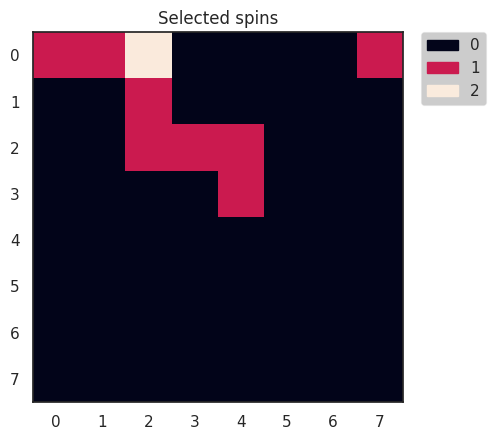

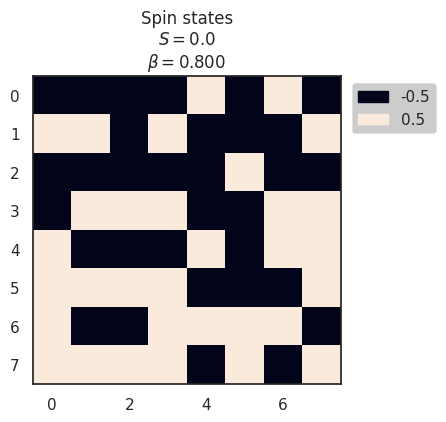

In [109]:
# Extended
# Bring the array back to the host and store it in a more agreeable numpy array
plot_selection = np.asarray(selection.selected).astype(int)
plot_selection[seed_idx] = 2
show(plot_selection, "Selected spins")
state.plot();

We can now use this selection to easily implement the Wolff algorithm

In [110]:
# Extended
# Taken from `jackpot/algorithms/wolff.py`
class DemonstrationWolffAlgorithm(ClusterAlgorithm):
    """
    Implementation of the Wolff algorithm.

    Notably features support for the Metropolis-Hastings-like acceptance
    modification used to enable working with systems that interact with the
    environment. This could, for example, be an external magnetic field or
    some other spin-lattice interaction that cannot be wrapped up in the
    clustering step.
    """

    def step(self, rng_key: RNGKey, state: State) -> State:
        raise NotImplementedError("Wolff is a cluster algorithm and can only sweep")

    def sweep(self, rng_key: RNGKey, state: State) -> State:
        point_key, spin_key, accept_key = random.split(key=rng_key, num=3)

        # First step is solving for the clusters
        solution = ClusterSolution.clusterise_state(rng_key=rng_key, state=state)

        # Next we find a cluster and select it
        seed_idx = get_random_point_idx(rng_key=point_key, shape=state.shape)
        current_spin = state.spins[tuple(seed_idx)]

        selection = ClusterSelection.from_seed_idx(
            cluster_solution=solution, seed_idx=seed_idx
        )

        # Set the cluster to our a new spin on our trial state
        trial_spin = get_trial_spin(
            rng_key=spin_key, state=state, current_spin=current_spin
        )
        trial_spins = jnp.where(selection.selected, trial_spin, state.spins)

        # Note: we cannot mutate PyTree, so we use Equinox convenience method
        # to produce a new tree with the changes we want
        where = lambda s: s.spins
        trial_state = eqx.tree_at(where, state, trial_spins)

        # Update number of steps taken
        new_steps = selection.selected.sum()
        where = lambda s: s.steps
        trial_state = eqx.tree_at(where, trial_state, trial_state.steps + new_steps)

        # Probabilistically select trial state
        # This is a standard technique when using external field or anisotropy
        # interactions.
        # It essentially adds a Metropolis-Hastings like transition probability
        # to the cluster update, which enables these dynamics in a way that
        # cannot be accomplished using link dynamics.

        # Note how the probabilistic_cluster_accept attribute is static
        # and we can thus statically compile the two different branches
        # of the condition rather than having to rely on a dynamic dispatch
        if self.probabilistic_cluster_accept:
            delta_H = state.model.get_hamiltonian(
                trial_state
            ) - state.model.get_hamiltonian(state)
            accept = metropolis_hastings_accept(
                rng_key=accept_key, beta=state.beta, delta=delta_H
            )

            new_state = lax.cond(accept, lambda: trial_state, lambda: state)

        else:
            new_state = trial_state

        return new_state

Having now implemented an algorithm suitable for use in the `jackpot` framework save for a few utility functions, we can now give our Wolff algorithm a try:

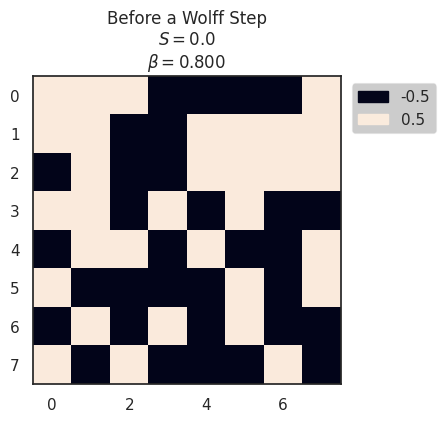

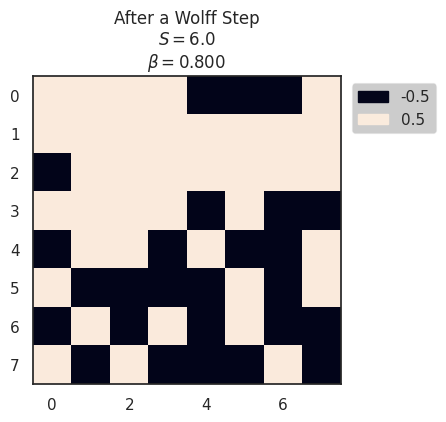

In [111]:
# Extended
demo_wolff_algorithm = DemonstrationWolffAlgorithm(probabilistic_cluster_accept=False)

# Let's make a new state where we use the algorithm we just made!
state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=2,
    size=8,
    beta=0.8,
    model=model,
    algorithm=demo_wolff_algorithm,
    id_=0,
)

state.plot(title="Before a Wolff Step")
new_state = state.evolve_sweeps(k.new, sweeps=1)
new_state.plot(title="After a Wolff Step");

### Scaling Simulations

For now we have only been working with a single state executing on a single device core. Although we have been using vectorised `ufunc` functions from the JAX `numpy` interface, we can and should vectorise further. If we were to simulate two states, we could improve our performance by vectorising _across_ both states! Implementing something like this by hand would be impractical at best, but fortunately the many restrictions imposed upon us by JAX now allow us to use _transformations_ to vectorise multiple states.

Let's try to implement vectorisation of our states. First, we will wrap the making of a state and the subsequent thermalisation of the state in a single function.

  0%|          | 0/250 [00:00<?, ?it/s]

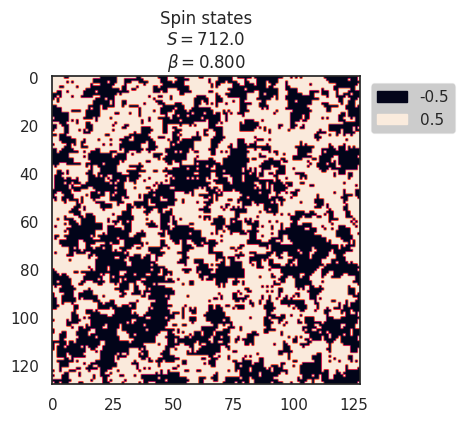

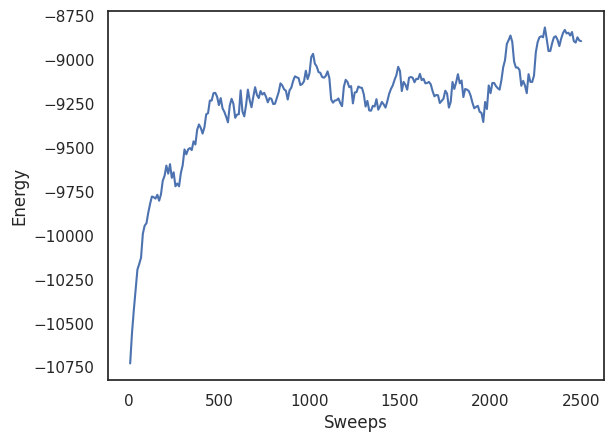

In [112]:
# Extended
def make_and_thermalise_state(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    known_total: int,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs state and thermalises it, returning measurements along the
    way in addition to the thermalised state.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        known_total: Known number of total iterations to use in progress bar,
        num_prints: Number of times to update the progress bar (approximately),
    """
    # Split key so we have one to use to make new state and one to evolve with
    rng_key, state_key = random.split(key=rng_key, num=2)

    # Construct state
    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        """
        Body function of a lax scan primitive.
        This scans across a number of xs and carries the state, returning
        a stack of measurements and the final state at the end.
        """
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(tqdm=tqdm, num_prints=num_prints, known_total=known_total)
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


# Try make a single state just like before, but using this new convenience function
thermalised_state, measurements = make_and_thermalise_state(
    k.new,
    dimensions=2,
    size=128,
    beta=0.8,
    id_=0,
    steps=250,
    sweeps_per_step=10,
    model=model,
    algorithm=demo_wolff_algorithm,
    known_total=250,
)
thermalised_state.block_until_ready()
# On my machine it takes ≈ 15 seconds to do the above for a 128x128 lattice
# This includes the compilation step
# Precompiled it takes ≈ 5 second
# Not bad!

# Show the state
thermalised_state.plot()

# Show measurements made along the way to prove that we have actually thermalised
# the state
_meas_df = measurements.to_df()
meas_df = _meas_df.explode(_meas_df.columns.tolist()).infer_objects()
meas_df["Sweeps"] = meas_df["sweeps"]
meas_df["Energy"] = meas_df["energy"]
plt.figure()
sns.lineplot(data=meas_df, x="Sweeps", y="Energy");

Above we haven't actually implemented any vectorisation. We are still just constructing and evolving a single state. Let's change that by vectorising our function:

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='Sweeps', ylabel='Energy'>

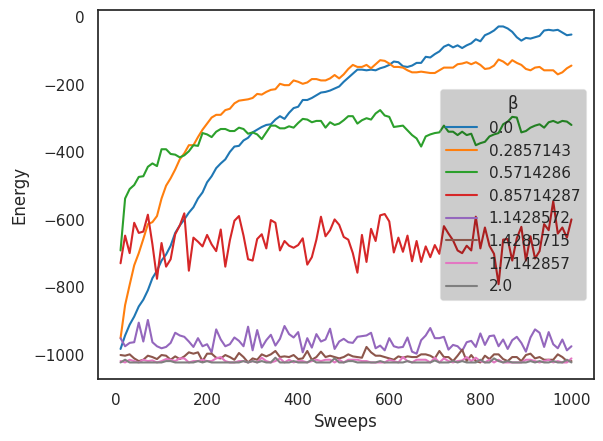

In [113]:
# Extended
# in_axes is a tuple denoting which axes we want to vectorise over and which
# we should broadcast. It follows the same order as the arguments are defined
# in on make_and_thermalise_state.
# None means broadcast, an integer `i` means broadcast along the `i`th axis of the input
in_axes = (
    0,  # rng_key: RNGKey,
    None,  # dimensions: int,
    None,  # size: int,
    0,  # beta: float,
    0,  # id_: int,
    None,  # steps: int,
    None,  # sweeps_per_step: int,
    None,  # model: Model,
    None,  # algorithm: Algorithm,
    None,  # known_total: int,
    None,  # num_prints: int = 10,
)
make_and_thermalise_states_vectorised = eqx.filter_vmap(
    make_and_thermalise_state, in_axes=in_axes, out_axes=0
)

# Make 8 different states and thermalise them
keys = k.shaped((8,))
betas = np.linspace(0, 2, 8, endpoint=True)
ids = np.arange(0, 8)
# Note: For technical reasons we lose the ability to use keyword arguments
# when using transformations
states, measurements = make_and_thermalise_states_vectorised(
    keys,
    2,
    32,
    betas,
    ids,
    100,
    10,
    model,
    demo_wolff_algorithm,
    100,
    10,
)

_meas_df = measurements.to_df()
meas_df = _meas_df.explode(_meas_df.columns.tolist()).infer_objects()
plt.figure()

meas_df["Energy"] = meas_df["energy"]
meas_df["β"] = meas_df["beta"]
meas_df["Sweeps"] = meas_df["sweeps"]
sns.lineplot(data=meas_df, x="Sweeps", y="Energy", hue="β", palette="tab10")

If we play around with the configuration above and execute our computations on a CPU, we will notice that vectorisation is not a significant benefit. We can expect to see more of a benefit of vectorisation on TPU's and GPU's.

How about parallising across multiple CPU cores (or TPU cores or GPU devices)? The following assumes you have at least 8 CPU cores, which will be the case for most modern systems.

  0%|          | 0/800 [00:00<?, ?it/s]

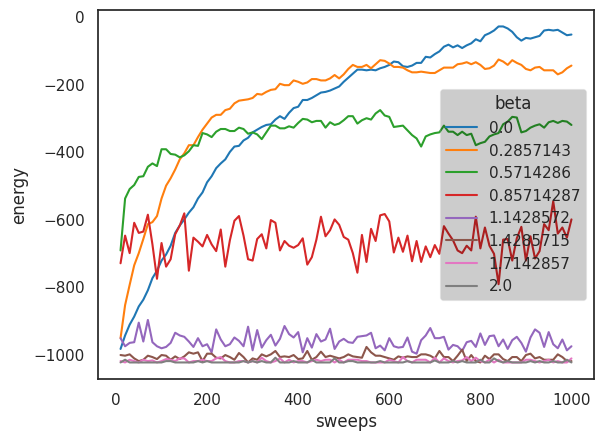

In [114]:
# Extended
make_and_thermalise_states_parallelised = eqx.filter_pmap(
    make_and_thermalise_state, in_axes=in_axes, out_axes=0
)

# Note: For technical reasons we lose the ability to use keyword arguments
# when using transformations
states, measurements = make_and_thermalise_states_parallelised(
    keys,
    2,
    32,
    betas,
    ids,
    100,
    10,
    model,
    demo_wolff_algorithm,
    800,
    10,
)

_meas_df = measurements.to_df()
meas_df = _meas_df.explode(_meas_df.columns.tolist()).infer_objects()
plt.figure()

sns.lineplot(data=meas_df, x="sweeps", y="energy", hue="beta", palette="tab10");

On my system when using CPU's, the above executes practically instantly. That is, we can fully thermalise 8 32x32 Ising Models in around a second.

We can combine several transformations in order to construct an _ensamble_ of states that is computed in the manner we desire. Generally it is advisable to transform in such a way that starting from the innermost transformation:
- Vectorisation occurs such that the _device_ memory is full. For example, if we have 8 TPU cores with 8 GB memory each, we should vectorise in such a way that our program and working memory combined takes up a little less than 8 GB of memory available on the device.
- Parallelisation occurs such that all available devices are utilised
- Any additional computation is done using the `filter_map` function that wraps the `lax.map` primitive. `filter_map` can be found in `jackpot/utils/map.py`

This ensures that devices spend as little time communicating with the host as possible, while also ensuring that all devices are used.

An example of how this is done can be seen in the `workbench.ipynb` notebook, which can be run manually to perform a simulation or may be parameterised using `papermill` and the parameters found in the `parameters/` folder.

For even larger scale computation, JAX supports distribution of computation across multiple hosts, each of which may have their own group of devices.

## Performance of Implementations
While the implementation of the Metropolis-Hastings algorithm in `jackpot` could be _significantly_ sped up by restating it as a checkerboard algorithm (Yang et al., 2019), it performs reasonably when parallelised across the 96 CPU cores of a `TPU v2-8` Google Cloud VM. Due to our implementation being a single-site Metropolis-Hastings algorithm, it is not suitable for the unique performance characteristics of a TPU in its current formulation.

The implementation of the Wolff algorithm is, however, well-suited for use with GPU and TPU hardware and if we compare the performance of our algorithm with that of the `numpy`-based implementation in (Timothy Budd, n.d.), we find that it offers a significant speed-up. The T. Budd implementation can be found in `notebooks/tbudd_wolff.ipynb` and has been modified for the purposes of benchmarking.

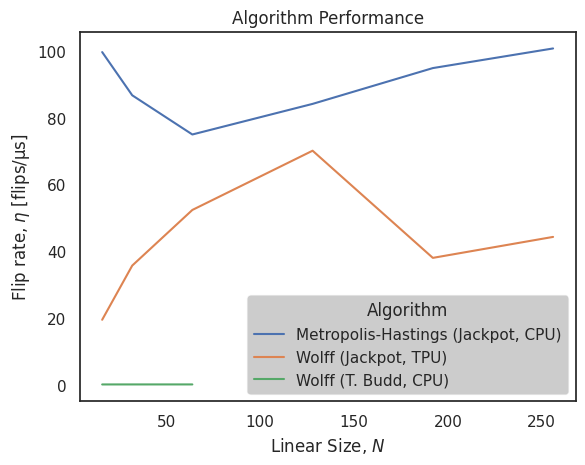

In [115]:
# Standard
performance_variables = []
for experiment in (root / "experiments" / "performance").glob("*"):
    if not experiment.is_dir():
        continue

    vars = {}
    with open(experiment / "saved_variables.json") as f:
        vars |= json.load(f)
    with open(experiment / "config.json") as f:
        vars |= json.load(f)

    performance_variables.append(vars)

perf_df = pd.DataFrame.from_records(performance_variables)
perf_df = perf_df[
    ["algorithm", "thermalise_compile_time", "thermalise_run_time", "flip_rate", "size"]
]
perf_df["algorithm"] = perf_df["algorithm"].replace(
    {
        "metropolis_hastings": "Metropolis-Hastings (Jackpot, CPU)",
        "wolff": "Wolff (Jackpot, TPU)",
    }
)
with open(root / "experiments" / "performance" / "tbudd_wolff_perf.json") as f:
    tbudd_perf = json.load(f)

tbudd_perf_data = []
for k, v in tbudd_perf.items():
    tbudd_perf_data.append(
        {"size": k, "flip_rate": v, "algorithm": "Wolff (T. Budd, CPU)"}
    )

perf_df = pd.concat([perf_df, pd.DataFrame.from_records(tbudd_perf_data)])
perf_df = perf_df.reset_index()
perf_df["size"] = perf_df["size"].astype(int)

ax = sns.lineplot(data=perf_df, x="size", y="flip_rate", hue="algorithm")
ax.set(xlabel="Linear Size, $N$", ylabel=r"Flip rate, $η \ \mathrm{[flips/μs]}$")
ax.get_legend().set_title("Algorithm")
plt.title("Algorithm Performance");

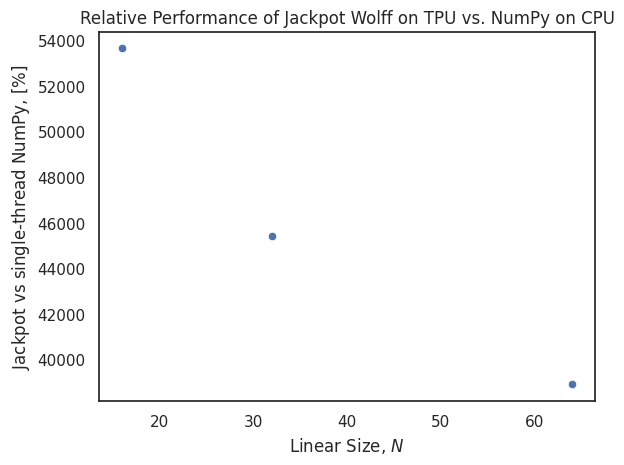

In [116]:
# Standard
perf_pivot = perf_df.pivot(index="size", columns="algorithm", values="flip_rate")
perf_pivot["speedup"] = (
    perf_pivot["Metropolis-Hastings (Jackpot, CPU)"]
    / perf_pivot["Wolff (T. Budd, CPU)"]
) * 100

ax = sns.scatterplot(data=perf_pivot, x="size", y="speedup")
ax.set(
    xlabel="Linear Size, $N$",
    ylabel=r"Jackpot vs single-thread NumPy, $\mathrm{[\%]}$",
)
plt.title("Relative Performance of Jackpot Wolff on TPU vs. NumPy on CPU");

This reveals a performance increase of our TPU-accelerated Wolff Algorithm when compared to a single-threaded NumPy implementation around 500×, which is an impressive improvement that unlocks the potential to study much larger lattice sizes.

The peak in the Wolff algorithm run on the TPU at $128×128$ lattice size can be explained the MXU size as detailed [Here](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm).

## Decorrelation Times of Different Algorithms

Given that we have built our statistical foundation in the first portion of the report on the ability to sample _uncorrelated_ configurations of a system, the time it takes for our algorithms to evolve a system to an effectively uncorrelated state is of vital importance and will reveal the weakness of local algorithms like the Metropolis-Hastings algorithm.

The autocorrelation data is collected using a JAX implementation of the `statsmodels.tsa.stattools.acf` function which can be found in `jackpot/primitives/_autocorrelate_statsmodels.py`. The implementation follows the mathematical description given in the theory section. The autocorrelation is done over 1000 measurements spaced 2 sweeps apart.

In [117]:
# Standard
# Load autocorrelation data
ac_df = pd.DataFrame()
for experiment in (root / "experiments" / "autocorrelation").glob("*"):
    with open(experiment / "config.json") as f:
        config = json.load(f)

    _ac_df = pd.read_feather(experiment / "ac_df.feather")
    _ac_df["size"] = config["size"]
    _ac_df["algorithm"] = config["algorithm"]

    ac_df = pd.concat([ac_df, _ac_df])

ac_df["Algorithm"] = ac_df["algorithm"].replace(
    {
        "wolff": "Wolff",
        "metropolis_hastings": "Metropolis-Hastings",
        "swendsen_wang": "Swendsen-Wang",
    }
)
ac_df["Size"] = ac_df["size"]

In [118]:
# Standard
ac_df.head(2)

,index,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,...,state.model.nuclear_magnetic_moment,state.id_,state.steps,state.sweeps,temp,size,algorithm,state.algorithm.probabilistic_cluster_accept,Algorithm,Size
0,0,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.15577562, 0.07034141, 0.033722278, -0....","[1.0, 0.18187144, 0.09970858, 0.049724445, -0....",1.087671,1.203049,1.111111,"[-0.5, 0.5]",...,1.0,0,3072000,12000,0.9,16,metropolis_hastings,NaN,Metropolis-Hastings,16
1,1,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.0861914, 0.046843123, 0.04635285, 0.03...","[1.0, 0.10915659, 0.04893061, 0.044354495, 0.0...",0.824639,0.908773,1.111111,"[-0.5, 0.5]",...,1.0,1,3072000,12000,0.9,16,metropolis_hastings,NaN,Metropolis-Hastings,16


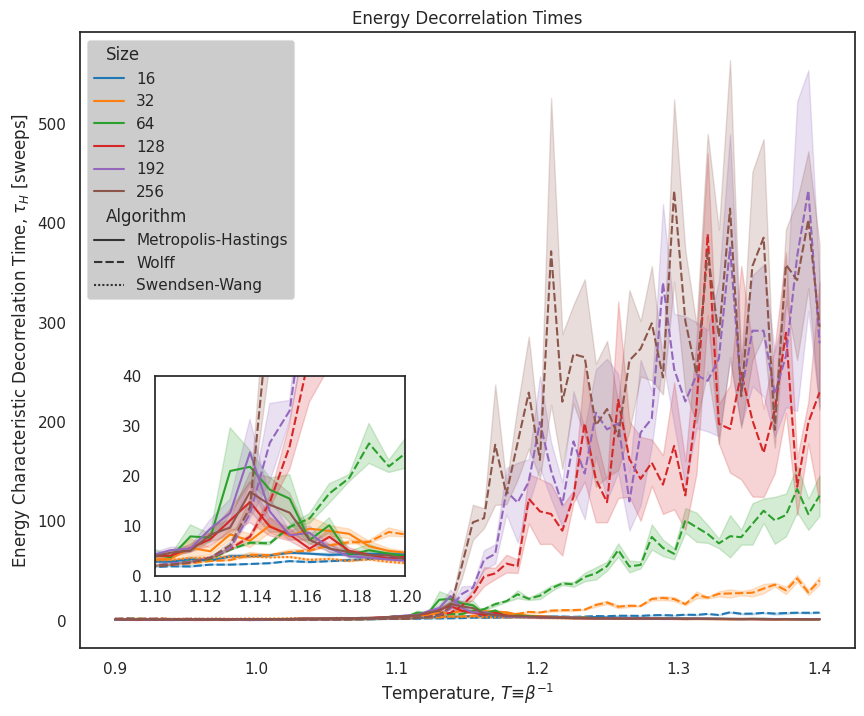

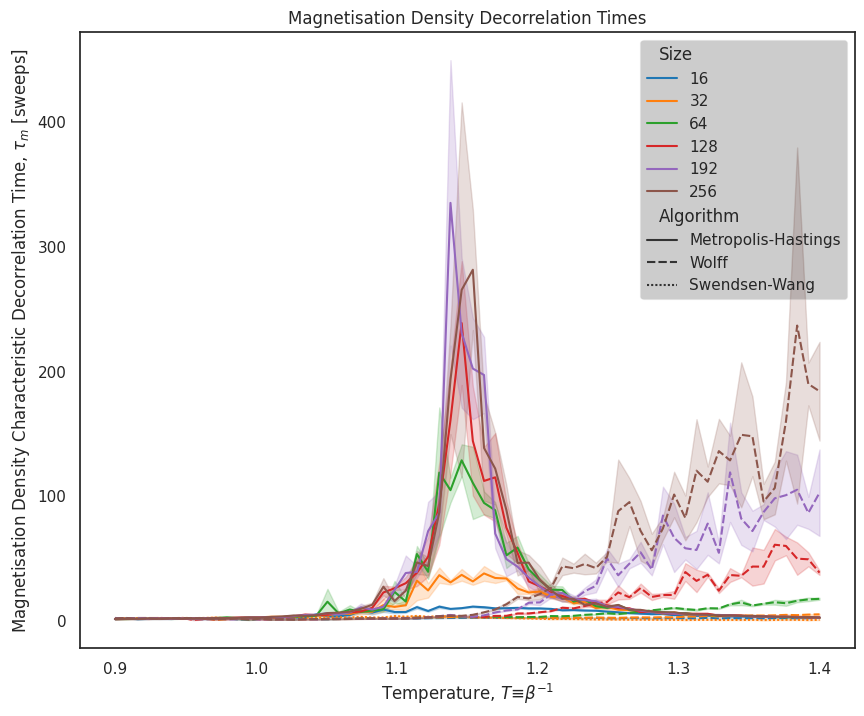

In [119]:
# Standard
# Plot energy decorrelation time
_ac_plot_kwargs = {
    "data": ac_df,
    "x": "temp",
    "hue": "Size",
    "style": "Algorithm",
    "palette": "tab10",
    "errorbar": "se",
    "n_boot": 500,
}
fig, e_ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.lineplot(ax=e_ax, y="energy_decay_time", **_ac_plot_kwargs)

e_ax2 = plt.axes([0.2, 0.2, 0.25, 0.25])
sns.lineplot(ax=e_ax2, y="energy_decay_time", **_ac_plot_kwargs)
e_ax2.get_legend().remove()
e_ax2.set(xlim=(1.1, 1.2), ylim=(0, 40), xlabel=None, ylabel=None)
e_ax.set(
    title="Energy Decorrelation Times",
    xlabel="Temperature, $T ≡ β^{-1}$",
    ylabel=r"Energy Characteristic Decorrelation Time, $τ_H\ \mathrm{[sweeps]}$",
)

# Plot magnetisation density decorrelation time
fig, md_ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.lineplot(ax=md_ax, y="magnetisation_density_decay_time", **_ac_plot_kwargs)
md_ax.set(
    title="Magnetisation Density Decorrelation Times",
    xlabel="Temperature, $T ≡ β^{-1}$",
    ylabel=r"Magnetisation Density Characteristic Decorrelation Time, $τ_m\ \mathrm{[sweeps]}$",
);

We notice a few important features of the different algorithms and their decorrelation times. Most importantly, the decorrelation time of the Metropolis-Hastings algorithms increases rapidly around the critical temperature as the lattice size grows. This is highly undesirable, as the critical temperature is generally the point around which we want to measure our observables in order to understand the phase transition. In fact, all _local_ lattice algorithms will suffer from this problem, which can be understood qualitatively by realising that the spin clusters are correlated over large distances around the critical temperature as outlined in the theory section. Flipping a single spin at a time makes it very difficult to evolve the system into a new configuration where the clustering of spins is uncorrelated to the previous configuration.

This is solved by clustering algorithms such as the Wolff algorithm and the Swendsen-Wang algorithm, where spins are probabilistically clustered together as discussed above. By flipping a whole cluster (which notably is not the whole correlated group of spins, but only a part of it), we can achieve an uncorrelated state much faster than we would be able to using a local algorithm.

The next important feature we notice is the fact that the Wolff algorithm seemingly struggles at higher temperatures. To understand this, we must recall that a sweep in the Wolff algorithm only flips a single cluster, whereas a sweep of the Metropolis-Hastings algorithm attempts to flip every spin in the system. The cluster size decreases as we go further into the unordered phase at higher temperatures, thus drastically reducing the fraction of the lattice spins that are flipped by the Wolff algorithm in a single sweep.

A solution to this could be the Swendsen-Wang algorithm, which uses the same clustering technique as the Wolff algorithm, but flips every cluster with a $50\%$ probability. A single run of the Swendsen-Wang algorithm was performed at $L=32$.

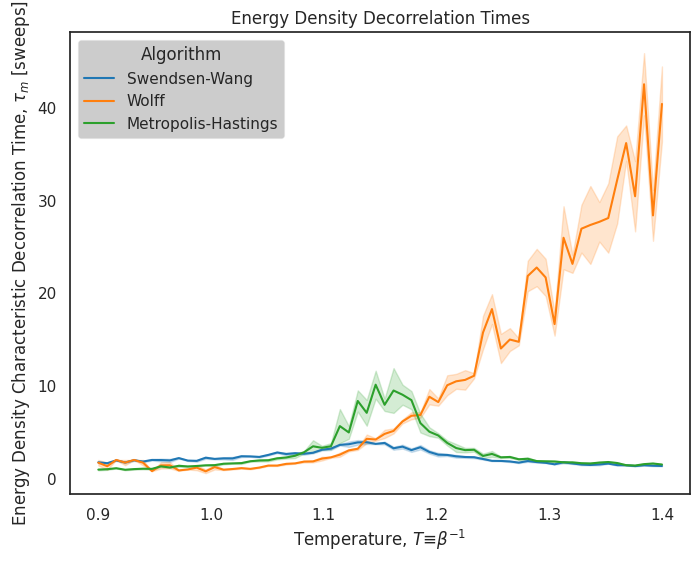

In [120]:
# Standard
# Plot L = 32 measurements
fig = plt.figure()
fig.set_size_inches(8, 6)
L32_ax = sns.lineplot(
    y="energy_decay_time",
    **_ac_plot_kwargs
    | {
        "data": ac_df.query("Size == 32"),
        "hue": "Algorithm",
        "style": None,
        "n_boot": 2500,
    }
)

L32_ax.set(
    title="Energy Density Decorrelation Times",
    xlabel="Temperature, $T ≡ β^{-1}$",
    ylabel=r"Energy Density Characteristic Decorrelation Time, $τ_m\ \mathrm{[sweeps]}$",
);

From this we can clearly see that the Swendsen-Wang algorithm does not suffer the same problem as the Wolff algorithm. Problematically, it is also much slower per sweep, as it requires flipping all the clusters, of which there are many at high temperatures.

One computationally efficient approach may be to select the algorithm to use depending on the system temperature, or alternatively apply a hybrid approach where the Wolff Algorithm and the Metropolis-Hastings algorithm are used in tandem to exploit their respective strengths. An example of this approach can be seen in (Ostmeyer et al., 2021).

We can further demonstrate the failure of the Wolff Algorithm by measuring the cluster size as a function of temperature.

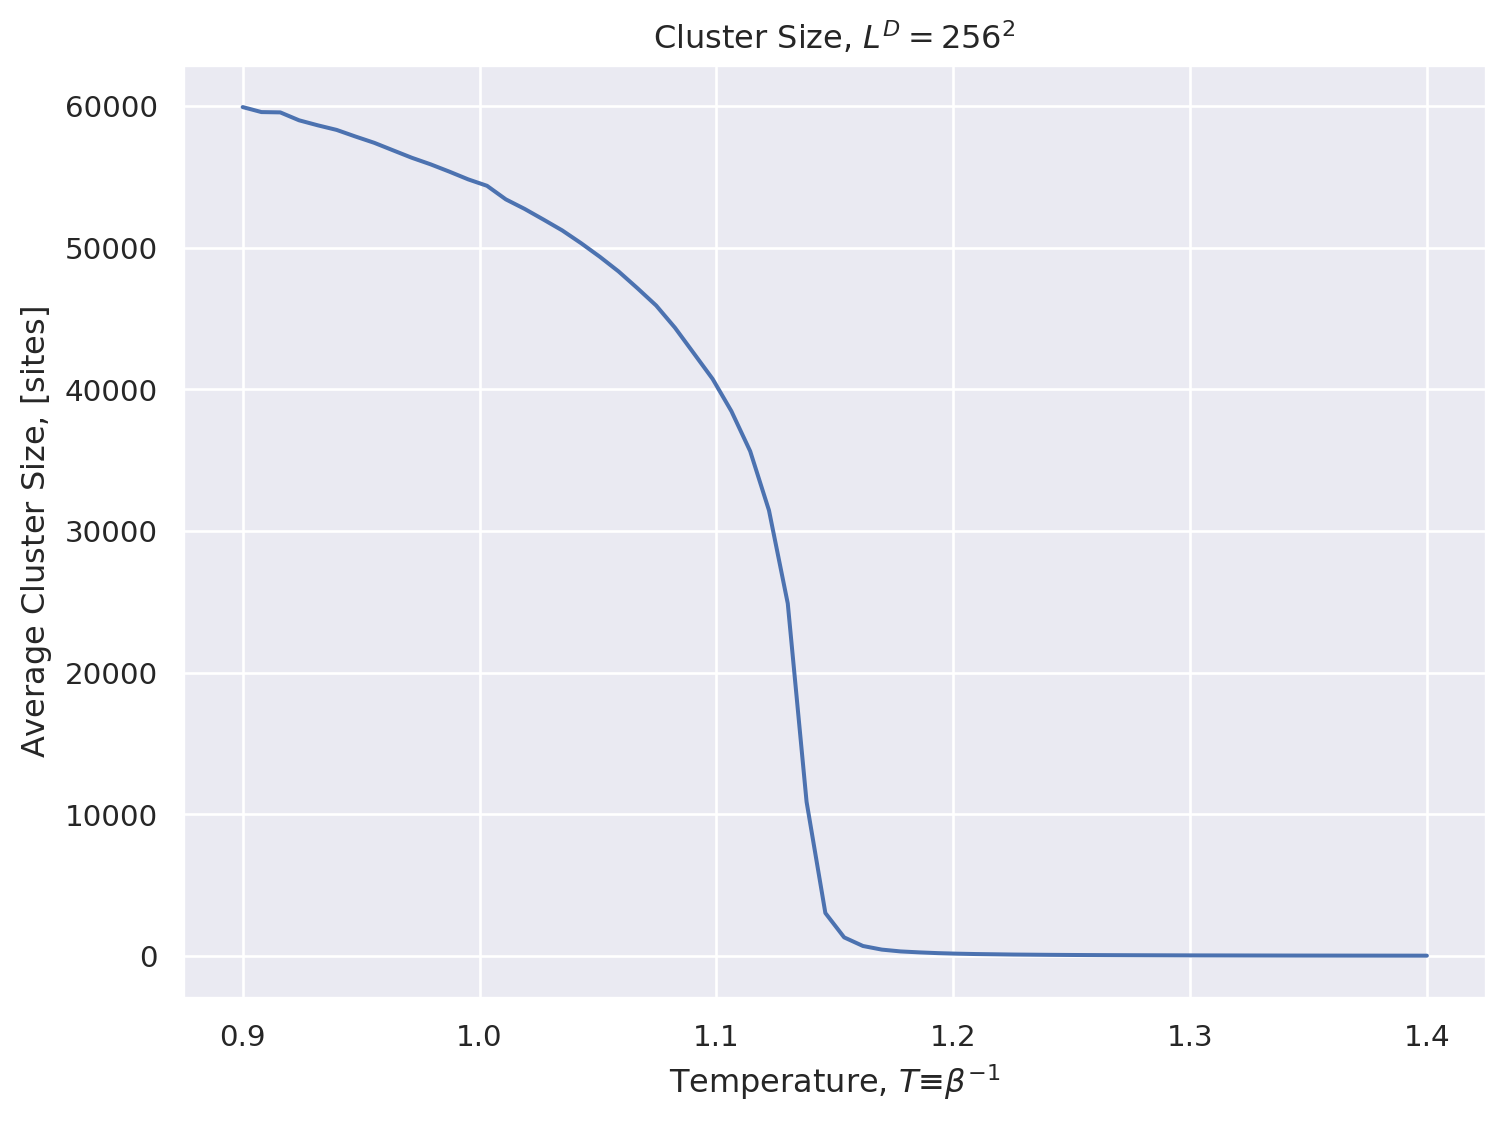

In [121]:
# Standard
# Load measurement data for largest measurement
meas_df = pd.read_feather(
    root / "experiments" / "measure_2D" / "N256_wolff" / "meas_df.feather"
)

# Calculate cluster size with errors based on Wolff data
cluster_df = meas_df.groupby("natural_temperature").agg(
    steps=("steps", "mean"), steps_sem=("steps", "sem"), sweeps=("sweeps", "first")
)
cluster_df["steps_min"] = cluster_df["steps"] - cluster_df["steps_sem"]
cluster_df["steps_max"] = cluster_df["steps"] + cluster_df["steps_sem"]
cluster_df["cluster_size"] = cluster_df["steps"] / cluster_df["sweeps"]
cluster_df["cluster_size_min"] = cluster_df["steps_min"] / cluster_df["sweeps"]
cluster_df["cluster_size_max"] = cluster_df["steps_max"] / cluster_df["sweeps"]

# Plot, note that 1σ confidence interval is too small to see
(
    so.Plot(
        cluster_df,
        x="natural_temperature",
        y="cluster_size",
        ymin="cluster_size_min",
        ymax="cluster_size_max",
    )
    .add(so.Line())
    .add(so.Band())
    .label(
        x="Temperature, $T ≡ β^{-1}$",
        y=r"Average Cluster Size, $\mathrm{[sites]}$",
        title="Cluster Size, $L^D = 256^2$",
    )
    .layout(size=(8, 6))
)

It now becomes very obvious why the Wolff algorithm decorrelation time measured in number of sweeps degrades after the critical point. One might argue that a decorrelation time measured in number of spins flipped is better, and this would indeed reveal the _flipping efficiency_ of an algorithm, but ultimately we are not concerned with the efficiency per flip, but rather efficiency per computing time, which is why a carefully selected hybrid algorithm is likely to be the optimal approach. Given the implementations of `jackpot` can still be substantially improved through optimization and profiling, this work has not been undertaken, but may yield profitable results given further study.  

## Measuring Physical Observables
By thermalising a set of systems and performing many uncorrelated measurements on them after they have reached thermal equilibrium, we can obtain measurements of the physical observables using the approaches described in the theory section.

We evolve and measure a set of systems at various lattice sizes using the Ising Model and the Wolff algorithm according to the following table:

| System Size | Thermalisation Sweeps |
| :---------: | :-------------------: |
| $16 × 16$   | $2500$                |
| $32 × 32$   | $2500$                |
| $64 × 64$   | $2500$                |
| $96 × 96$   | $5000$                |
| $128 × 128$ | $5000$                |
| $160 × 160$ | $10000$               |
| $192 × 192$ | $10000$               |
| $224 × 224$ | $15000$               |
| $256 × 256$ | $15000$               |

With the additional parameters being the same across all system sizes:
- 256 systems evolved, 64 different temperatures with 4 different samples of each
- Temperatures linearly spaced between 0.9 and 1.4
- 25 copies of thermalised states made which are then separately evolved 100 times with 50 sweeps between measurements
- 2 Dimensional with $1/2$ spin configuration


In [122]:
# Standard
# Load observation data – precomputed due to lengthy bootstrapping procedure
# Data prepared using `notebooks/measurements.ipynb` notebook.

obs_df = pd.read_feather(
    root / "experiments" / "measure_2D" / "observation_summary.feather"
)
obs_df.head(2)

,temp,size,dimensions,energy_dens_mean,energy_dens_var,energy_dens_sem,energy_dens_mean_min,energy_dens_mean_max,energy_dens_var_sem,abs_mag_dens_mean,...,mag_sus_fluctuation_max,mag_sus_gradient,binder_2_mean,binder_2_sem,binder_2_min,binder_2_max,binder_4_mean,binder_4_sem,binder_4_min,binder_4_max
0,0.900000,16,2,-0.928833,0.001437,0.000379,-0.929212,-0.928454,2.939109e-07,0.478046,...,0.061384,0.099472,-0.000944,0.000858,-0.001802,-0.000086,-0.001191,0.000553,-0.001744,-0.000638
1,0.907937,16,2,-0.926396,0.001498,0.000387,-0.926783,-0.926009,3.078764e-07,0.477256,...,0.062366,0.135475,-0.000970,0.000871,-0.001841,-0.000100,-0.001227,0.000562,-0.001789,-0.000665


<Figure size 640x480 with 0 Axes>

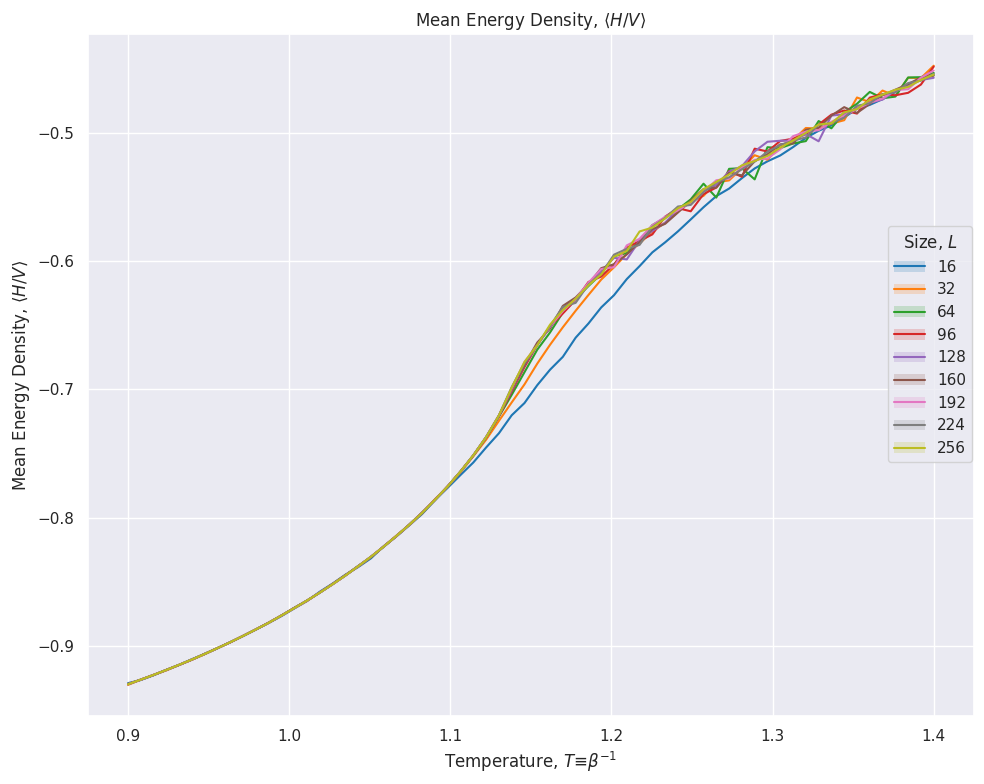

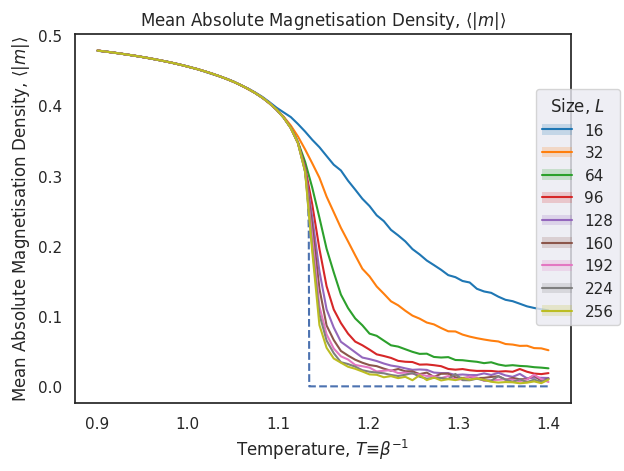

In [123]:
# Standard
def plot_obs(obs_df: pd.DataFrame, obs_name: str, obs_label: str, on: None = None):
    """
    Ploting convenience function.
    """
    # Determine if this observation has error estimation
    has_errors = f"{obs_name}_min" in obs_df.columns
    ymin = None
    ymax = None
    if has_errors:
        ymin = f"{obs_name}_min"
        ymax = f"{obs_name}_max"

    plot = (
        so.Plot(
            data=obs_df,
            x="temp",
            y=obs_name,
            ymin=ymin,
            ymax=ymax,
            color="size",
        )
        .scale(color="tab10")
        .add(so.Line())
        .theme({"figure.figsize": (10, 8)})
        .label(
            x="Temperature, $T ≡ β^{-1}$",
            y=obs_label,
            color="Size, $L$",
            title=f"{obs_label}",
        )
    )

    if has_errors:
        plot = plot.add(so.Band())

    if on is not None:
        plot = plot.on(on)

    return plot

# Plot energy density
plt.figure()
plot_obs(
    obs_df, "energy_dens_mean", r"Mean Energy Density, $\langle H/V\rangle$"
).show()


# Plot magnetisation density
fig, ax = plt.subplots()
plot = plot_obs(
    obs_df,
    "abs_mag_dens_mean",
    r"Mean Absolute Magnetisation Density, $\langle |m|\rangle$",
    on=ax,
)

# Get theoretical result, see (Timothy Budd, n.d.)
temps = np.linspace(0.9, 1.4, 1000)
sinh = np.sinh(1 / temps)
clip_sinh = np.clip(sinh, a_min=1.0, a_max=np.inf)
inner = 1 - np.power(clip_sinh, -4)
theory_mag_dens = np.power(inner, 1 / 8) * 0.5

ax.plot(temps, theory_mag_dens, "--")
plot.show()
fig.show()

We note some "jitter" at higher temperatures which is not captured by our error estimates. This is due to the errors arising from the poor performance of the Wolff algorithm at higher temperatures. The measured configurations at high temperatures simply are not fully decorrelated due to insufficient evolving between measurements. This could be remedied by evolving for longer between each measurement, but this is computationally expensive. Improvements to the algorithm or changing to a hybrid approach would make it tractible to measure states that are less correlated even at higher temperatures.

Otherwise we note that the energy density and absolute magnetisation density confirm the findings of existing literature. We can see that as $L→ ∞$, our absolute magnetisation density plot approaches the theoretical Onsager result indicated as a dashed line.

Note that both axes are scaled by $0.5$ compared to literature that use a more traditional $±1$ spin value system.

<Figure size 640x480 with 0 Axes>

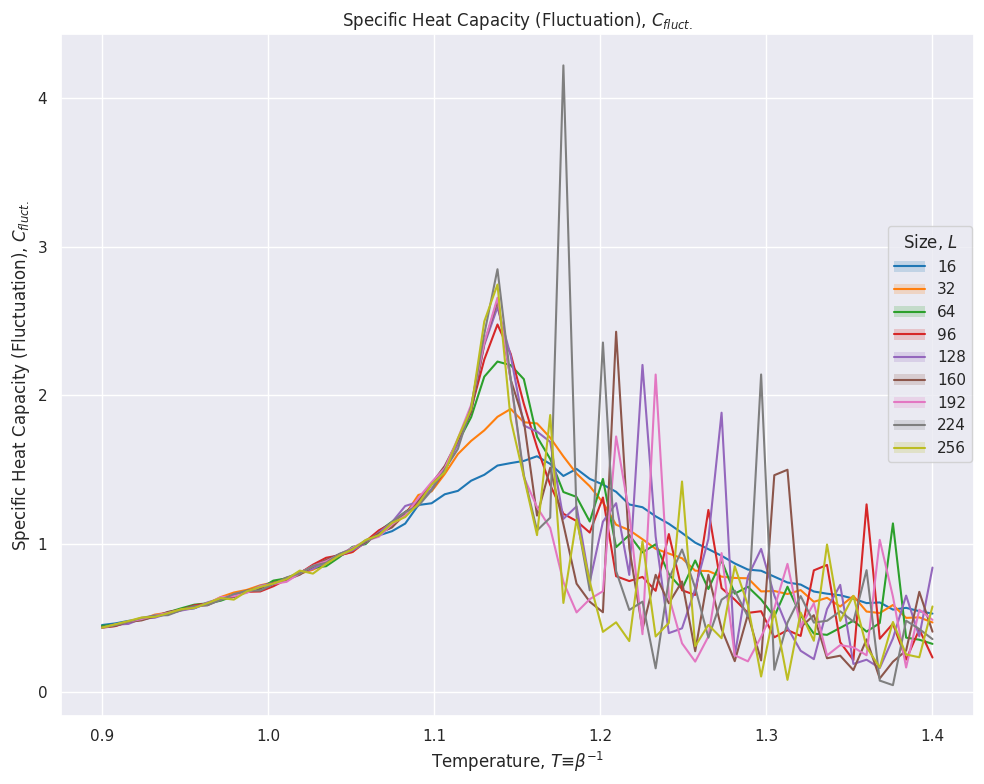

<Figure size 640x480 with 0 Axes>

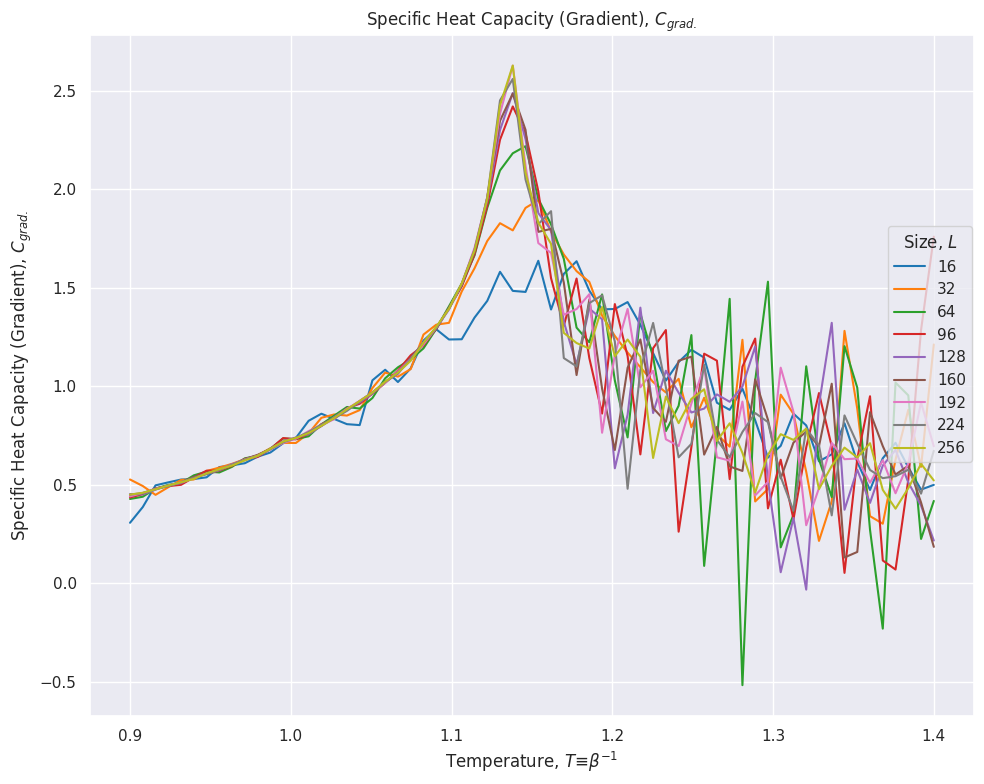

In [124]:
# Standard
# Plot specific heat capacity
plt.figure()
plot_obs(
    obs_df,
    "specific_heat_cap_fluctuation",
    r"Specific Heat Capacity (Fluctuation), $C_{fluct.}$",
).show()

plt.figure()
plot_obs(
    obs_df,
    "specific_heat_cap_gradient",
    r"Specific Heat Capacity (Gradient), $C_{grad.}$",
).show()

The specific heat capacites which are calculated using the fluctuation-dissipation theorem approach and thermodynamic gradient approach respectively are in good agreement, but severely affected by the correlated measurements at high temperatures. It would be possible to make estimates of the various critical exponents using the data depicted above, though we would likely require better data and ideally larger lattice sizes.

In [125]:
# Extended
# Set up a model function. See theory above
def magnetisation_critical_fit(temperature, critical_temperature, scale, beta):
    reduced_temp = temperature - critical_temperature
    value = scale * np.abs(reduced_temp) ** beta
    return value


fit_df = obs_df.query("temp < 1.15")
fits = {}


def fit_group(group):
    # Apply fit to each size
    model = lmfit.Model(magnetisation_critical_fit)
    params = model.make_params()

    # Make reasonably initial guesses
    params["critical_temperature"].set(value=1.3, min=1.0, max=1.5)
    params["scale"].set(value=1.0, min=0.0, max=np.inf)
    params["beta"].set(value=1 / 8, min=0.0, max=1.0)

    temperatures = group["temp"]
    values = group["abs_mag_dens_mean"]
    fit = model.fit(data=values, params=params, temperature=temperatures)

    data = {}
    for param_name, param in fit.params.items():
        data[param_name] = param.value
        data[param_name + "_se"] = param.stderr

    data["rsq"] = fit.rsquared

    return pd.Series(data)


mag_crit_df = fit_df.groupby("size").apply(fit_group).reset_index()
mag_crit_df

,size,critical_temperature,critical_temperature_se,scale,scale_se,beta,beta_se,rsq
0,16,1.134865,0.000725,0.538358,0.004842,0.084948,0.003463,0.959081
1,32,1.151555,0.001092,0.583822,0.004894,0.134380,0.004510,0.990955
2,64,1.147435,0.000441,0.593339,0.006554,0.140723,0.005208,0.983934
3,96,1.088541,0.005202,0.511594,0.042443,0.065585,0.028570,0.178129
4,128,1.146204,0.000102,0.607366,0.010318,0.152011,0.007622,0.969794
5,160,1.146104,0.000050,0.611862,0.011800,0.155755,0.008622,0.964804
6,192,1.146057,0.000038,0.616941,0.013710,0.160008,0.009943,0.958406
7,224,1.146048,0.000034,0.621182,0.015631,0.163553,0.011273,0.950191
8,256,1.146045,0.000084,0.624812,0.016384,0.166766,0.011700,0.948231


As we expected, our fits are not terribly good, but we do get some estimates of the critical values at least.

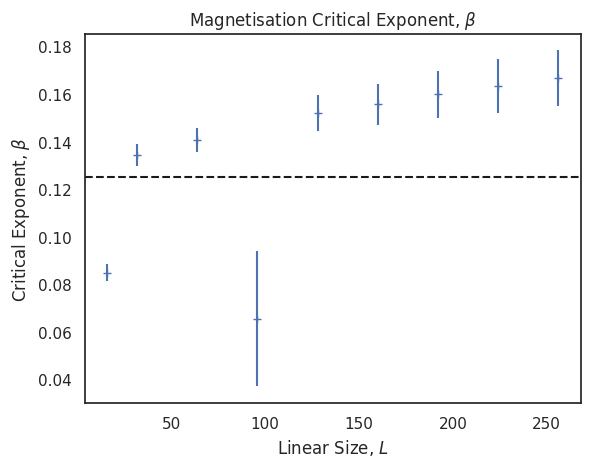

In [126]:
# Extended
plt.figure()
plt.title("Magnetisation Critical Exponent, $β$")
plt.errorbar(mag_crit_df["size"], mag_crit_df["beta"], mag_crit_df["beta_se"], fmt="+")
plt.axhline(1 / 8, c="k", ls="--")
plt.xlabel("Linear Size, $L$")
plt.ylabel("Critical Exponent, $β$");

We are quite far from the true value, but critical exponents are notoriously difficult to determine. We can probably do better by constraining some parameters, but we are just hoping to get a feel for the exponents rather than actually determine them with any confidence. We can try the heat capacity exponent as well:

In [127]:
# Extended
# Set up a model function. See theory above
def heat_cap_critical_fit(temperature, critical_temperature, scale, alpha):
    reduced_temp = temperature - critical_temperature
    value = scale * np.abs(reduced_temp) ** (-alpha)
    return value


fit_df = obs_df.query("temp < 1.10")
fits = {}


def fit_group(group):
    # Apply fit to each size
    model = lmfit.Model(heat_cap_critical_fit)
    params = model.make_params()

    # Make reasonably initial guesses
    params["critical_temperature"].set(value=1.3, min=1.0, max=2.0)
    params["scale"].set(value=1.0, min=0.0, max=np.inf)
    params["alpha"].set(value=0.0, min=-5.0, max=5.0)

    temperatures = group["temp"]
    values = group["specific_heat_cap_fluctuation"]
    fit = model.fit(data=values, params=params, temperature=temperatures)

    data = {}
    for param_name, param in fit.params.items():
        data[param_name] = param.value
        data[param_name + "_se"] = param.stderr

    data["rsq"] = fit.rsquared

    # To see all residuals, uncomment:
    # fit.plot()

    return pd.Series(data)


heat_cap_crit_df = fit_df.groupby("size").apply(fit_group).reset_index()
heat_cap_crit_df

,size,critical_temperature,critical_temperature_se,scale,scale_se,alpha,alpha_se,rsq
0,16,1.079023,0.001223,0.405989,0.037348,0.212359,0.024452,0.761668
1,32,1.300145,0.038608,0.104808,0.007668,1.602518,0.230871,0.996279
2,64,1.273027,0.023926,0.107404,0.006722,1.463449,0.146565,0.997783
3,96,1.351618,0.039444,0.094828,0.003335,1.939356,0.237762,0.998088
4,128,1.314815,0.031158,0.096996,0.004899,1.732184,0.190643,0.998047
5,160,1.285114,0.026070,0.102786,0.006211,1.547627,0.160288,0.997851
6,192,1.261547,0.023626,0.108511,0.007621,1.406535,0.146761,0.997357
7,224,1.360704,0.035837,0.096904,0.002543,1.968441,0.212879,0.998587
8,256,1.272555,0.027778,0.107906,0.007839,1.454305,0.169410,0.996990


Text(0, 0.5, 'Critical Exponent, $α$')

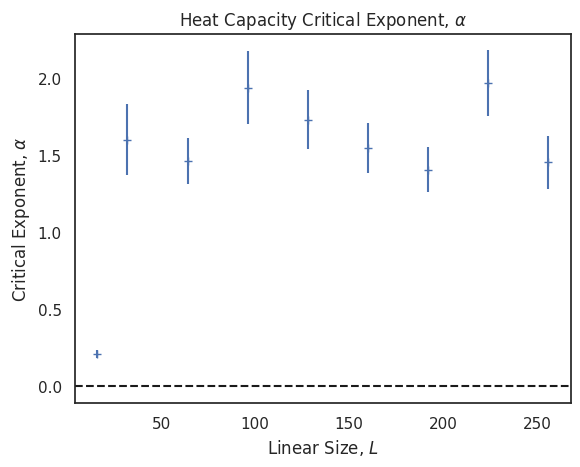

In [128]:
# Extended
plt.figure()
plt.title("Heat Capacity Critical Exponent, $α$")
plt.errorbar(
    heat_cap_crit_df["size"],
    heat_cap_crit_df["alpha"],
    heat_cap_crit_df["alpha_se"],
    fmt="+",
)
plt.axhline(0.0, c="k", ls="--")
plt.xlabel("Linear Size, $L$")
plt.ylabel("Critical Exponent, $α$")

We notice that we get really good fits to the model function, but that our estimates of $α$ are consistently much higher than expected. This is due to the order parameter not being able to diverge to infinity as expected by the theory due to a finite lattice size. Our peak is effectively suppressed – there may exist objective functions in the literature that take this into consideration, or alternatively much larger lattice sizes are needed to accurately determine the critical exponents accurately.

We can also study the magnetisation susceptibility, which follows the approaches above.

<Figure size 640x480 with 0 Axes>

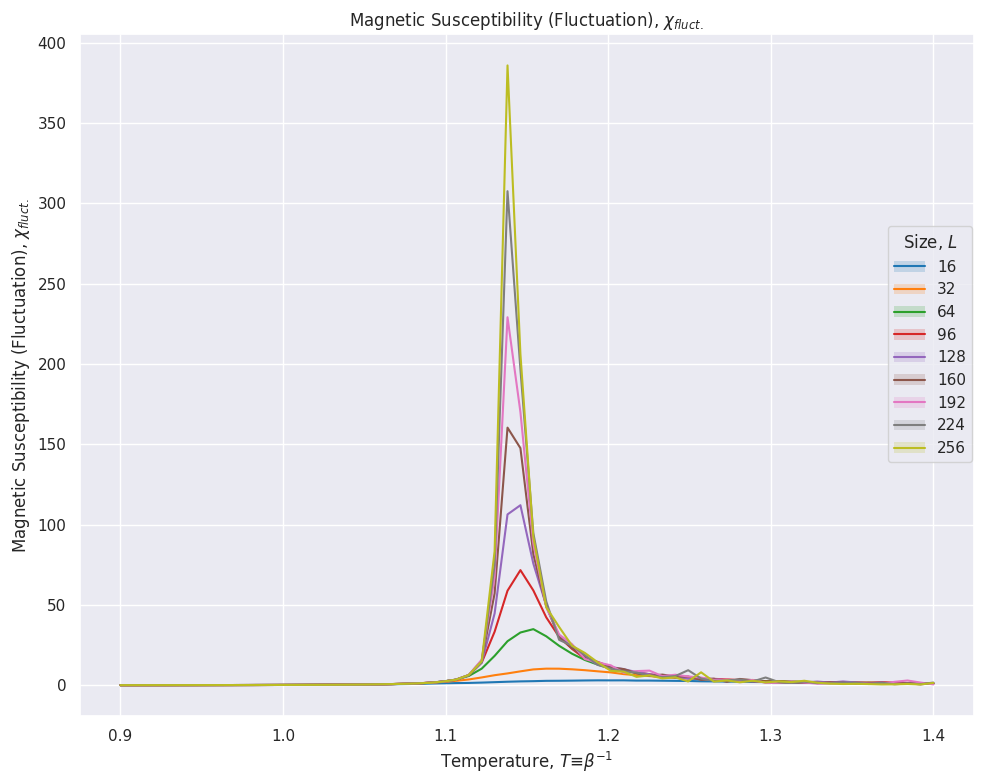

<Figure size 640x480 with 0 Axes>

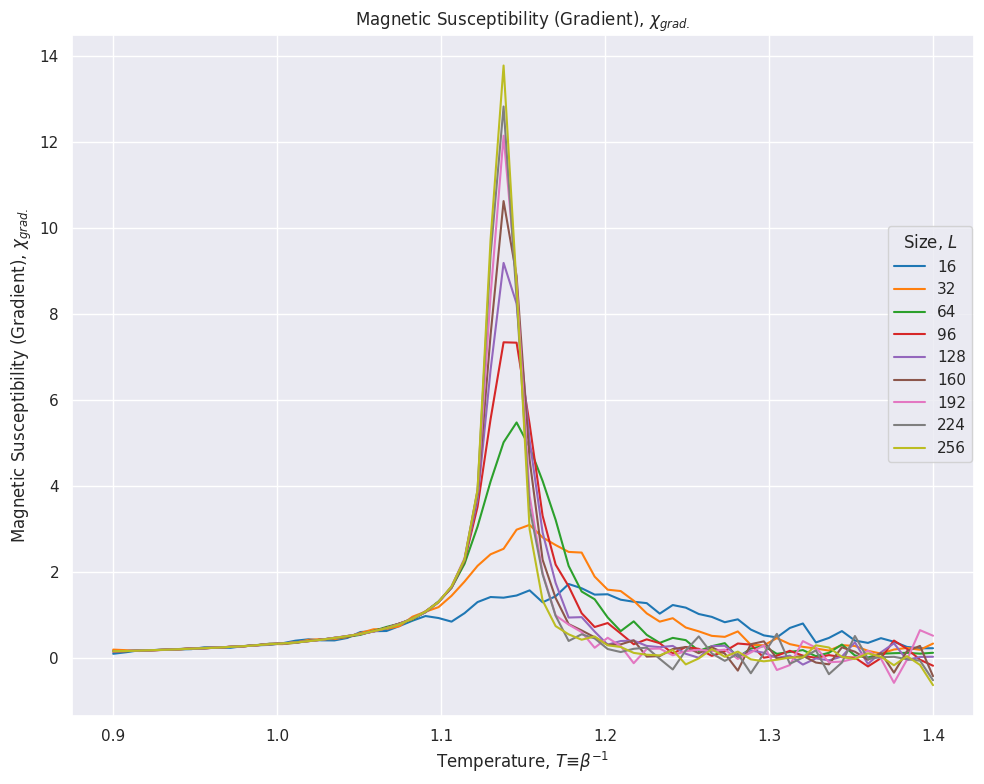

In [129]:
# Standard
# Plot Magnetic Susceptibility
plt.figure()
plot_obs(
    obs_df,
    "mag_sus_fluctuation",
    r"Magnetic Susceptibility (Fluctuation), $χ_{fluct.}$",
).show()

plt.figure()
plot_obs(
    obs_df,
    "mag_sus_gradient",
    r"Magnetic Susceptibility (Gradient), $χ_{grad.}$",
).show()

In [130]:
# Extended
# Set up a model function. See theory above
def mag_sus_critical_fit(temperature, critical_temperature, scale, gamma):
    reduced_temp = temperature - critical_temperature
    value = scale * np.abs(reduced_temp) ** (-gamma)
    return value


fit_df = obs_df.query("temp < 1.10")
fits = {}


def fit_group(group):
    # Apply fit to each size
    model = lmfit.Model(mag_sus_critical_fit)
    params = model.make_params()

    # Make reasonably initial guesses
    params["critical_temperature"].set(value=1.1, min=1.0, max=2.0)
    params["scale"].set(value=1.0, min=0.0, max=np.inf)
    params["gamma"].set(value=7 / 4, min=0, max=5.0)

    temperatures = group["temp"]
    values = group["specific_heat_cap_fluctuation"]
    fit = model.fit(data=values, params=params, temperature=temperatures)

    data = {}
    for param_name, param in fit.params.items():
        data[param_name] = param.value
        data[param_name + "_se"] = param.stderr

    data["rsq"] = fit.rsquared

    # To see all residuals, uncomment:
    # fit.plot()

    return pd.Series(data)


mag_sus_crit_df = fit_df.groupby("size").apply(fit_group).reset_index()
mag_sus_crit_df

,size,critical_temperature,critical_temperature_se,scale,scale_se,gamma,gamma_se,rsq
0,16,1.544498,0.115971,0.125743,0.028675,2.880498,0.641559,0.997443
1,32,1.300145,0.038608,0.104808,0.007668,1.602518,0.230872,0.996279
2,64,1.273027,0.023926,0.107404,0.006722,1.463450,0.146569,0.997783
3,96,1.351618,0.039442,0.094828,0.003335,1.939355,0.237755,0.998088
4,128,1.314814,0.031156,0.096996,0.004900,1.732183,0.190633,0.998047
5,160,1.285115,0.026071,0.102786,0.006211,1.547632,0.160300,0.997851
6,192,1.261547,0.023627,0.108511,0.007621,1.406539,0.146770,0.997357
7,224,1.360704,0.035836,0.096904,0.002543,1.968441,0.212878,0.998587
8,256,1.272556,0.027779,0.107906,0.007839,1.454308,0.169420,0.996990


Text(0, 0.5, 'Critical Exponent, $γ$')

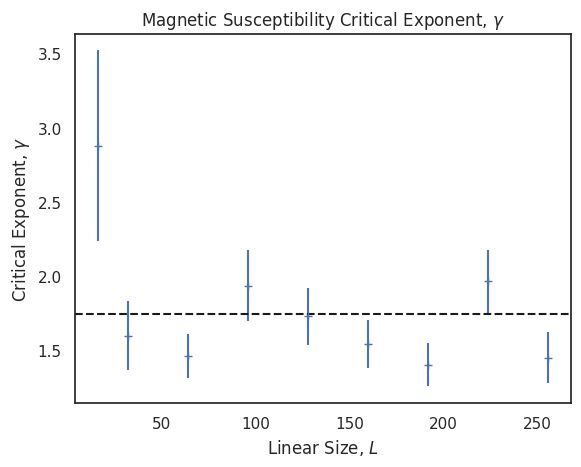

In [131]:
# Extended
plt.figure()
plt.title("Magnetic Susceptibility Critical Exponent, $γ$")
plt.errorbar(
    mag_sus_crit_df["size"],
    mag_sus_crit_df["gamma"],
    mag_sus_crit_df["gamma_se"],
    fmt="+",
)
plt.axhline(7 / 4, c="k", ls="--")
plt.xlabel("Linear Size, $L$")
plt.ylabel("Critical Exponent, $γ$")

We get surprisingly good fits for the $γ$ critical exponent. This is possibly related to the fact that our measured magnetisation data suffered less than the energy measurements from the limited thermalisation time between measurements. Given more time, it would be interesting to return to the simulations and run them for longer in order to see whether better estimates can be made.

## Determination of the Critical Temperature, $T_c$
Our last set of order parameters are the 2nd and 4th order Binder cumulants, which we can use to accurately determine the critical temperature. Conveniently, the crossing of Binder cumulants measured on systems of different lattice sizes will be located at the critical temperature of an infinitely sized lattice. Thus, we have a way to determine the critical point that works despite the location of criticalityof other observables being dependent on the lattice size.

Again, the calculation of the Binder cumulants is straight forward, with the expressions for the cumulants being presented in the theory section. The manipulation is done in the `notebooks/measurements.ipynb` notebook to avoid cluttering the report.

In [132]:
# Standard
# We use interpolation and root finding to find the crossings
def make_get_interp(dependent_var):
    def get_interp(group):
        return interp1d(
            group["temp"],
            group[dependent_var],
            kind="linear",
            # fill_value="extrapolate",
        )

    return get_interp


# Set up interpolation functions
interps_2 = (
    obs_df.query("1.00 <= temp <= 1.25")
    .groupby("size")
    .apply(make_get_interp("binder_2_mean"))
    .tolist()
)
interps_4 = (
    obs_df.query("1.00 <= temp <= 1.25")
    .groupby("size")
    .apply(make_get_interp("binder_4_mean"))
    .tolist()
)

# Find crossings of every combination
crossings_2 = []
crossings_4 = []
for interps, crossings in zip([interps_2, interps_4], [crossings_2, crossings_4]):
    for interp1, interp2 in it.combinations(interps, 2):
        difference = lambda x: interp1(x) - interp2(x)
        root_sol = optimize.root_scalar(
            difference, x0=1.13, x1=1.14, bracket=(1.1, 1.15)
        )
        assert root_sol.converged

        crossings.append(root_sol.root)

T_c_2 = np.mean(crossings_2)
T_c_4 = np.mean(crossings_4)
T_c_2_se = scipy.stats.sem(crossings_2)
T_c_4_se = scipy.stats.sem(crossings_4)
T_c_theory = 1 / np.log(1 + 2**0.5)
print(f"Binder 2: T_c = {T_c_2:.5f}±{T_c_2_se:.5f}")
print(f"Binder 4: T_c = {T_c_4:.5f}±{T_c_4_se:.5f}")
print(f"Theory  : T_c = {T_c_theory:.5f}")

T_c_est = (T_c_4 + T_c_2) / 2
T_c_est_sd = 0.5 / (2 * 64)
print(f"Est:    : T_c = {T_c_est:.5f}±{T_c_est_sd:.5f}")

Binder 2: T_c = 1.13275±0.00013
Binder 4: T_c = 1.13260±0.00011
Theory  : T_c = 1.13459
Est:    : T_c = 1.13267±0.00391


We can see that our results are impressively close to the theoretical result. We can make some nice plots to show what is going on aswell. The confidence intervals are standard errors ($±1σ$) and found by bootstrapping.

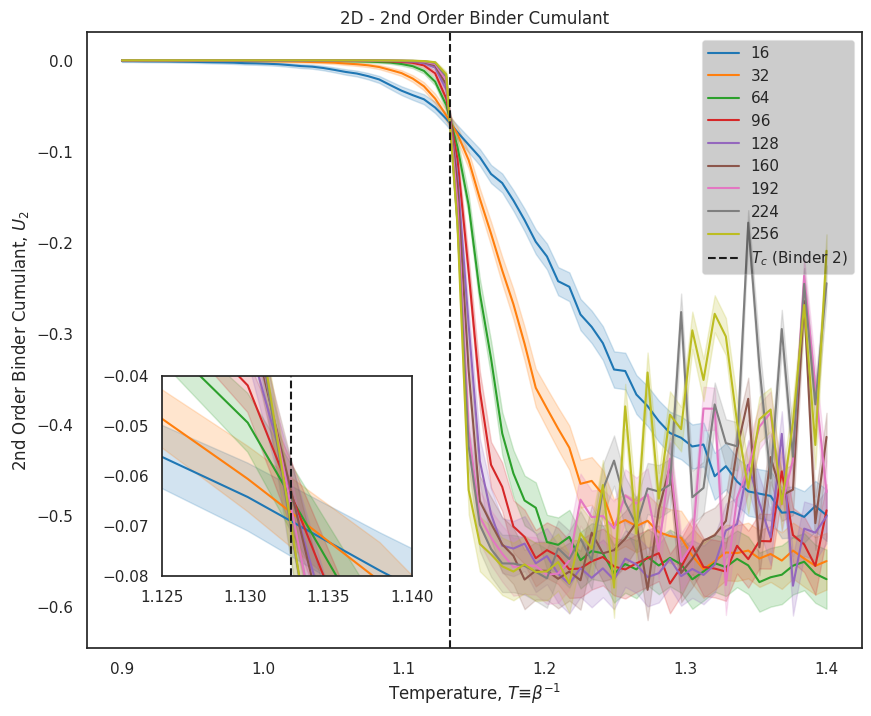

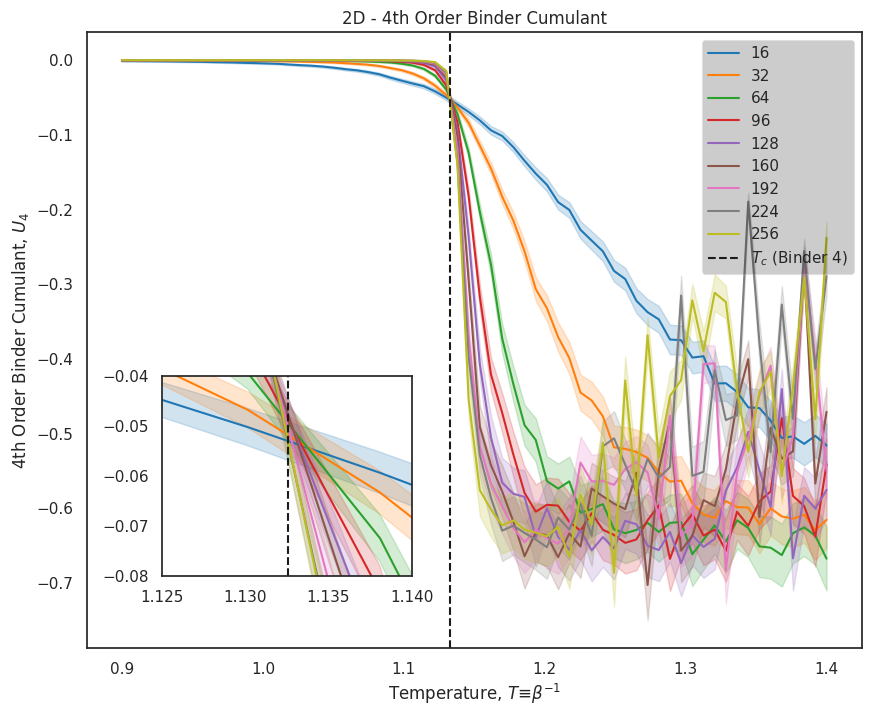

In [133]:
# Standard
def lineplot(data, y, ax):
    ax = sns.lineplot(
        ax=ax,
        data=data,
        x="temp",
        y=y,
        hue="size",
        palette="tab10",
    )

    for i, (name, group) in enumerate(data.groupby("size")):
        _x = group["temp"]
        _y = group[y]
        
        err_parts = y.split("_")
        err_parts[-1] = "sem"
        err = "_".join(err_parts)
        
        _err = group[err]
        color = ax.get_lines()[i].get_c()

        lower = _y - _err
        upper = _y + _err
        ax.fill_between(_x, lower, upper, alpha=0.2, color=color)


for order in [2, 4]:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    lineplot(obs_df, f"binder_{order}_mean", ax)

    ax2 = plt.axes([0.2, 0.2, 0.25, 0.25])
    lineplot(obs_df, f"binder_{order}_mean", ax2)
    ax2.get_legend().remove()
    ax2.set(xlim=(1.125, 1.140), ylim=(-0.08, -0.04), xlabel=None, ylabel=None)
    ordinal = "2nd" if order == 2 else "4th"
    ax.set(
        title=f"2D - {ordinal} Order Binder Cumulant",
        xlabel="Temperature, $T ≡ β^{-1}$",
        ylabel=f"{ordinal} Order Binder Cumulant, $U_{{{order}}}$",
    )

    for _ax in [ax, ax2]:
        T_c = T_c_2 if order == 2 else T_c_4
        _ax.axvline(x=T_c, ls="--", c="k", label=f"$T_c$ (Binder {order})")

    ax.legend(loc="upper right")

Given the how relatively coarse our measurements along the temperature axis ($ΔT = 0.5 / 64 ≈ 0.0078$), we can see that we're within half a temperature interval of the theoretical value. A tighter bound on the critical temperature could be established by greatly narrowing the range of temperatures over which the experiment is conducted. While this would allow very accurate determination of the infinite lattice critical temperature, $T_c(∞)$, those measurements would not give a very good picture of how the other order parameters behave at different temperatures.

If we disregard a strict statistical approach, we may conclude the determined value of the critical temperature as the mean of the two estimates with an error of half the temperature interval:

$$
T_c(D=2, L=∞, J=1, H=0) = 1.133±0.004
$$


While computationally more demanding, we can also produce an estimate of the critical temperature of a 3D Ising Model. Again we evolve and measure various lattice sizes using the Ising Model and the Wolff algorithm according to the following table:

| System Size | Thermalisation Sweeps |
| :---------: | :-------------------: |
| $8 × 8$     | $2500$                |
| $16 × 16$   | $2500$                |
| $24 × 24$   | $2500$                |
| $32 × 32$   | $2500$                |
| $40 × 40$   | $5000$                |
| $48 × 48$   | $5000$                |
| $56 × 56$   | $10000$               |
| $64 × 64$   | $10000$               |

With the additional parameters being the same across all system sizes:
- 256 systems evolved, 64 different temperatures with 4 different samples of each
- Temperatures linearly spaced between $2.225$ and $2.275$.
- 4 copies of thermalised states made which are then separately evolved 100 times with 50 sweeps between measurements
- 3 Dimensional with $1/2$ spin configuration

Ideally more measurements would be taken in order to reduce the error on the Binder cumulants and more accurately estimate the critical point.

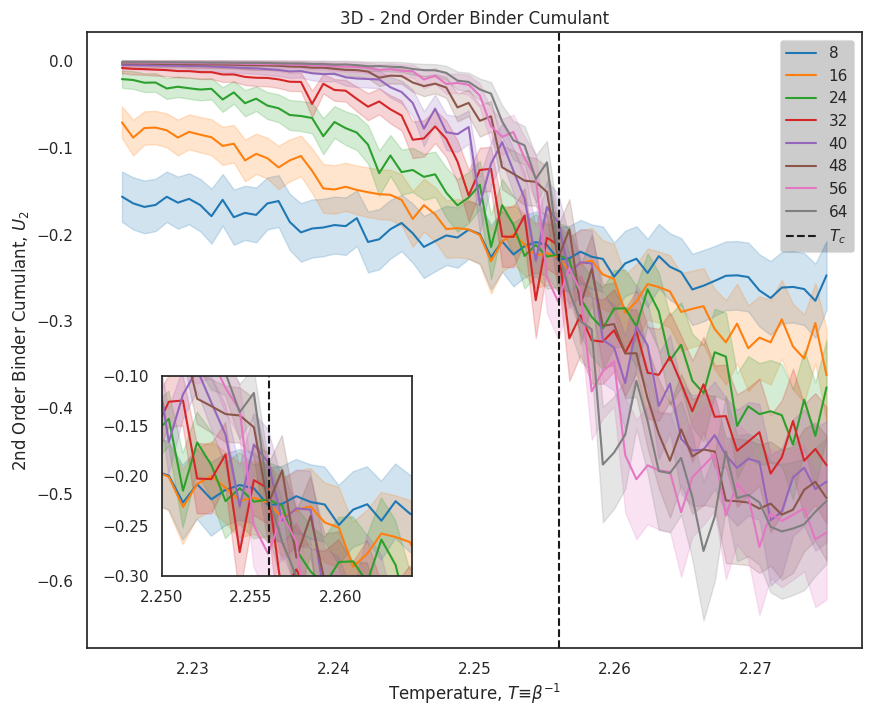

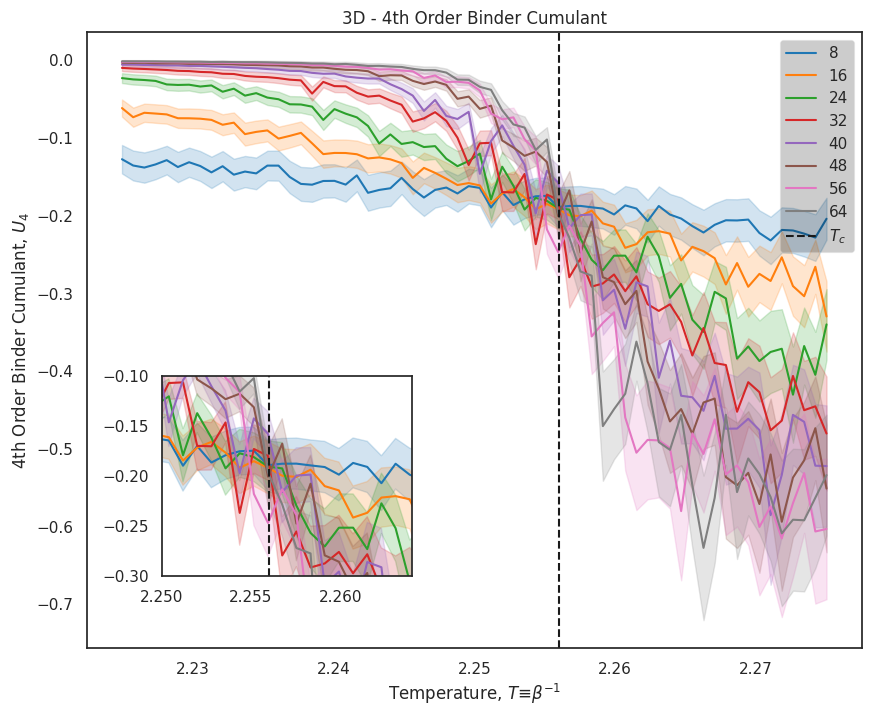

In [134]:
# Standard

# Load Data
obs_3d_df = pd.read_feather(
    root / "experiments" / "measure_3D_1" / "observation_summary.feather"
)

# Display data
for order in [2, 4]:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    lineplot(obs_3d_df, f"binder_{order}_mean", ax)

    ax2 = plt.axes([0.2, 0.2, 0.25, 0.25])
    lineplot(obs_3d_df, f"binder_{order}_mean", ax2)
    ax2.get_legend().remove()
    ax2.set(xlim=(2.25, 2.264), ylim=(-0.3, -0.1), xlabel=None, ylabel=None)
    ordinal = "2nd" if order == 2 else "4th"
    ax.set(
        title=f"3D - {ordinal} Order Binder Cumulant",
        xlabel="Temperature, $T ≡ β^{-1}$",
        ylabel=f"{ordinal} Order Binder Cumulant, $U_{{{order}}}$",
    )
    
    T_c = 2.256

    for _ax in [ax, ax2]:
        _ax.axvline(x=T_c, ls="--", c="k", label=f"$T_c$")

    ax.legend(loc="upper right")

Note that the data was too noisy to find the crossings using a straight interpolation. The crossing was therefore determined by hand and we apply conservative bounds on our obtained critical temperature as a result. As for the 2D measurement, the uncertainty is to be taken as a bound rather than a normally distributed standard error.

From the analysis, we find that:

$$
T_c(D=3, L=∞, J=1, H=0) = 2.256±0.002
$$

While no analytical results exists for the critical temperature of a 3D Ising Model, our result is in agreement with other results found in the literature (Preis et al., 2009). Note again that many some articles will use $s_i ∈ \{±1\}$, which leads to a factor 2 increase in the critical temperature.


## Discussion and Further Work

Many of the results presented through the report could be improved either by allowing more computation time to be spent simulating the systems or by improving the efficiency of the existing implementations. While the existing implementations easily outperform relative simple implementations that use `numpy` and Python-side loops, it is likely that there are still order-of-magnitude improvements that could be made, especially if targetting specialised hardware such as GPU's or TPU's, with the latter being an extreme example that yields incredible performance in cases where the problem can be turned into matrix operations. Additionally, changing the underlying datatype from a `float32` to the lower resolution `bfloat16` could yield vast improvements in performance on TPU's, though care must be taken to ensure the reduced float resolution does not negatively impact the correctness of the simulation.

Implementing a checkerboard Metropolis-Hastings algorithms as done in (Yang et al., 2019) and adding additional Wolff steps for systems at nearly critical temperatures would likely offer a very significant improvement in performance and allow higher dimensional models to be explored.

While the critical exponents prove difficult to determine bounds for, the infinite lattice critical temperature $T_c(∞)$ was established with good confidence and agreement with the theoretical value.

Additionally, `jackpot` can be used to implement more advanced lattice models such as the _Potts model_, _XY model_, or the _Heisenberg model_ in an efficient, scalable and idiomatic manner. Alternatively, further work on the project could explore hybrid algorithms or implement additional algorithms to complement the existing four.

Lastly, the existing _Ising model_ implementation offers a variety of interaction effects that may be toggled and tuned using the parameters of the model. Further simulations with these effects enabled could be undertaken with the potential to relate these to the behaviour of physical condensed matter systems. Additionally, further study of the model may be undertaken by increasing the dimensionality of the system.

## Conclusion

Along with a brief outline of the relevant physical and computational theory, we have presented the `jackpot` framework which can serve as an example of how to implement scientific simulations or data processing in a highly scalable, efficient manner, or alternatively the framework may be used in its own right to perform simulations of lattice models, which are constructed without reference to the lattice algorithm to avoid unnecessary coupling.

The unique constraints of the JAX library were presented and computation leveraging the exotic Tensor Processing Unit architecture from Google was demonstrated.

The $α$, $β$, and $γ$ critical exponents were estimated with relatively modest accuracy for a two-dimensional lattice using the Wolff algorithm, whose performance was compared to the Metropolis-Hastings and Swendsen-Wang algorithms. 

The critical temperature of an infinite 2D Ising Model was determined as $T_c(D=2, L=∞, J=1, S=1/2) = 1.133±0.004$, which is in agreement with the theoretical value of $1.13459$. Similarly, the critical temperature of an infinite 3D Ising Model was determined as $
T_c(D=3, L=∞, J=1, H=0) = 2.256±0.002$, which is in agreement with existing literature.


## Acknowledgements
I wish to thank Google for providing generous access to free `TPU v2-8` and `TPU v3-8` machines through their TPU Research Cloud (TRC, Google, n.d.) programme. 2 of the 110 machines offered were used for this project.

Additionally, the JAX team and the creator of Equinox, Patrick Kidger, were very helpful and responsive when approached regarding bugs or feature requests of their respective libraries, and I want to acknowledge their commitment to improving their Open Source contributions to the scientific computing community.

## References
- van der Maas, H.L.J., Dalege, J., Waldorp, L., 2020. The polarization within and across individuals: the hierarchical Ising opinion model. Journal of Complex Networks 8, cnaa010. https://doi.org/10.1093/comnet/cnaa010
- XLA, Google, n.d. XLA: Optimizing Compiler for Machine Learning [WWW Document]. TensorFlow. URL https://www.tensorflow.org/xla (accessed 4.21.23).
- TPU, Google, n.d. Train and run machine learning models faster | Cloud TPU [WWW Document]. Google Cloud. URL https://cloud.google.com/tpu (accessed 4.21.23).
- TRC, Google, n.d. TPU Research Cloud - About [WWW Document]. URL https://sites.research.google/trc/about/ (accessed 4.21.23).
- Taheridehkordi, A., Zivieri, R., 2020. Critical behavior of the classical spin-1 Ising model: a combined low-temperature series expansion and Metropolis Monte Carlo analysis. arXiv:2007.08593 [cond-mat].
- Strecka, J., Jaščur, M., 2015. A brief account of the Ising and Ising-like models: Mean-field, effective-field and exact results 65.
- Selke, W., 2006. Critical Binder cumulant of two-dimensional Ising models. Eur. Phys. J. B 51, 223–228. https://doi.org/10.1140/epjb/e2006-00209-7
- Timothy Budd, n.d. 6. Criticality & Cluster algorithms — Monte Carlo Techniques [WWW Document]. URL https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html (accessed 4.23.23).
- Lundow, P.H., Campbell, I.A., 2018. Hyperscaling breakdown and Ising spin glasses: The Binder cumulant. Physica A: Statistical Mechanics and its Applications 492, 1838–1852. https://doi.org/10.1016/j.physa.2017.11.101
- Kidger, P., Garcia, C., 2021. Equinox: neural networks in JAX via callable PyTrees and filtered transformations. https://doi.org/10.48550/arXiv.2111.00254
- Yang, K., Chen, Y.-F., Roumpos, G., Colby, C., Anderson, J., 2019. High Performance Monte Carlo Simulation of Ising Model on TPU Clusters. https://doi.org/10.48550/arXiv.1903.11714
- deLyra, J.L., 2006. The Wolff Algorithm with External Sources and Boundaries.
- Ostmeyer, J., Berkowitz, E., Luu, T., Petschlies, M., Pittler, F., 2021. The Ising Model with Hybrid Monte Carlo. Computer Physics Communications 265, 107978. https://doi.org/10.1016/j.cpc.2021.107978
- Preis, T., Virnau, P., Paul, W., Schneider, J.J., 2009. GPU accelerated Monte Carlo simulation of the 2D and 3D Ising model. Journal of Computational Physics 228, 4468–4477. https://doi.org/10.1016/j.jcp.2009.03.018
